# UHS1–4 EA & AA HIV Acquisition GWAS: baseline (1df) & G$\times$Sex (2df)

__Author__: Jesse Marks <br>
**GitHub Issue**: [#97](https://github.com/RTIInternational/bioinformatics/issues/42)

This document revisits the data processing on the combined UHS1–4 data sets; partitioned by ancestry (AA & EA). 

## Data locations
**Phenotype (unprocessed)**: 

* `s3://rti-hiv/hiv_uhs1234/data/phenotype/unprocessed/hiv_all_merged_with_uhs_all_phenotype_data_08282017.csv.gz`

**Genotype Data:**
* `s3://rti-hiv/hiv_uhs1234/data/genotype/observed`

## Data Description
### genotype 
```
ww *fam
  4025 aa_studies_merged_chrx.fam
  4026 aa_studies_merged.fam` 
  
  3021 ea_studies_merged_chrx.fam
  3023 ea_studies_merged.fam
```

### phenotype data 
We want to be consistent with the variables that were used in the previous HIV acquisition GWAS of combined data UHS123. The file on S3 `s3://rti-hiv/uhs_data/pheno/uhs_hiv_acq_baseline_phenotype_20180502.txt` shows which variables were used for that  HIV acquisition GWAS <br>
**variables**:
```
	hiv_status
	race_rec
	sex_rec
    age
```

We will pull those variables from the master phenotype file (which is also located at s3://rti-heroin/hiv_all_merged_with_uhs_all_phenotype_data_08282017.csv.gz). 

## Software and tools
The software and tools used for processing these data are

* [Amazon Elastic Compute Cloud(EC2)](https://aws.amazon.com/ec2/)
* GNU bash version 4.1.2
* [PLINK v1.9 beta 3.45](https://www.cog-genomics.org/plink/)
* [EIGENSOFT v4.2](https://www.hsph.harvard.edu/alkes-price/software/)
* [R v3.2.3](https://www.r-project.org/)
* [ProbABEL](https://github.com/GenABEL-Project/ProbABEL)

# Download Data and Create Directory Structure

In [ ]:
## bash ##

### create directory structure ###
genoD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/observed/ # location of QC'ed genotype data
gwasD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/gwas/1df # base processing dir
phenoD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype # base phenotype dir
eig=$phenoD/processing/eig # location of PCA processing dir
ancestry_list="ea aa"
study=uhs1234
mkdir -p $genoD $gwasD $phenoD/{final,processing,unprocessed} $eig/results 

### Download data & unzip ###

# Prepare files for Analysis
Note that we follow the process outlined in the NGC protocol for preperations of the phenotype file, even if we don't ultimately use RVTESTS for the analysis. This is so that the phenotype processing steps are consistent.

## Phenotype processing
Create phenotype files for GWAS. As mentioned above, we will extract the ids of subjects passing the genotype QC and the subset the master phenotype file down to these subjects and the variables listed above.

* Map sex coding and hiv status per the NGC protocol, to 1=female & 2=male and 1=control & 2=case.

### Data wrangling
The UHS123 phenotype files (EA & AA) were constructed previously and are at the locations:
* `s3://rti-hiv/uhs_data/fang_processing/pheno_hiv_aa_probabel`
* `s3://rti-hiv/uhs_data/fang_processing/pheno_hiv_ea_probabel`

We will use these data and append the UHS4 phenotype data to the end. First, we will get the UHS4 genotype IDs and then map them to the phenotype data. After that we will append these UHS4 phenotype data to the end of the previously generated UHS123 phenotype data. Then we will make sure to filter down to just the IDs that passed genotype QC and were imputed.

**Note** that we have developed a Python module to map the UHS4 genotype IDs to the phenotype data from the master phenotype file. We will use this here.

In [ ]:
## Bash ##
# get uhs4 genotype ids
cut -d " " -f1 /shared/jmarks/hiv/uhs1234/chrx_processing/data/uhs4/genotype/observed/aa/uhs4.aa.chr23.1KG.structure.fam > \
    $phenoD/processing/uhs4_aa_genotype_ids.txt
cut -d " " -f1 /shared/jmarks/hiv/uhs1234/chrx_processing/data/uhs4/genotype/observed/aa/uhs4.aa.chr23.1KG.structure.fam >\
    $phenoD/processing/uhs4_aa_genotype_ids.txt
"""
ww uhs4*
 1072 uhs4_aa_genotype_ids.txt
  988 uhs4_ea_genotype_ids.txt
"""

#### Map UHS4 genotype IDs to phenotype data
**geno_to_pheno.py**

In [ ]:
## Python3 ##
import pandas as pd
import os, itertools
os.chdir("/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing")

def main():

    phenotype_file = "../unprocessed/hiv_all_merged_with_uhs_all_phenotype_data_08282017.csv"
    genotype_file = "uhs4_aa_genotype_ids.txt" # geno ids to map to pheno
    var_list = ["hiv_status", "race_rec", "sex_rec", "age"]
    date = "20190528"  # today's date
    out_suffix = "uhs4_aa_hiv_acquistition_phenotype_file.txt" # suffix of outfile
    out_file = "{}_{}".format(date, out_suffix)

    df = pd.read_csv(phenotype_file, dtype=str) 
    cell_d, serum_d, gwas_d = gp_map(phenotype_file, var_list, df)
    filter_ids(genotype_file, var_list, out_file, cell_d, serum_d, gwas_d)



################################################################################
# view head of dictionaries
def glance(d, size):
    return dict(itertools.islice(d.items(), size))

def gp_map(phenotype_file, var_list, df):
    # initialized dictionaries that capture the variables-of-interest information for all subjects in phenotype file
    cell_dic = {}
    serum_dic = {}
    gwas_dic = {}

    for row in range(len(df)):
        # initialize list for key-value in dictionary
        cell_dic[df.loc[row, "cell_line"]] = []
        serum_dic[df.loc[row, "serum"]] = []
        gwas_dic[df.loc[row, "gwasserum"]] = []

        for var in var_list:
            cell_dic[df.loc[row, "cell_line"]].append(df.loc[row, var])
            serum_dic[df.loc[row, "serum"]].append(df.loc[row, var])
            gwas_dic[df.loc[row, "gwasserum"]].append(df.loc[row, var])

    print("Finished creating the genotype to phenotype map.\n")
    return cell_dic, serum_dic, gwas_dic

def newline(dic, identifier, otherline, outF):
    line = "\t".join(str(x) for x in dic[identifier])
    line = "{}\t{}".format(otherline.strip(), line)
    outF.write(line + "\n")

def filter_ids(genotype_file, var_list, out_file, cell_d, serum_d, gwas_d):
    with open(genotype_file) as inF, open(out_file, "w") as outF:
        field1 = "genotype_ID"
        head = "\t".join(var_list)
        head = "{}\t{}\n".format(field1, head)
        outF.write(head)
        line = inF.readline()
        while line:
            sl = line.split("_")
            asnum = sl[0] 
            hhg = sl[2]

            if hhg in cell_d:
                newline(cell_d, hhg, line, outF)
            elif asnum in serum_d:
                newline(serum_d, asnum, line, outF)
            elif asnum in gwas_d:
                newline(gwas_d, asnum, line, outF)
            else:
                print("Didn't find the following ID:\n")
                print(line)
                print(hhg)
            line = inF.readline()
    print("All done filtering down to the genotype IDs of interest jess.")
    print("your file is saved to: %s" %  out_file)


################################################################################
if __name__ == "__main__":
    main()

#### Combine phenotype data
Combine the previously generated phenotype file for the UHS123 HIV acquisition GWAS with the newly mapped UHS4 phenotype data. Note that we will combine all of these data (EA with the AA subgroup) and then partition out by assigned ancestry afterwards.

In [ ]:
## Bash ##

# combine UHS123 phenotype data and remove PCs associated with these data
cat $phenoD/unprocessed/pheno_hiv_aa_probabel /
    <(tail -n +2 $phenoD/unprocessed/pheno_hiv_ea_probabel) |\
    cut -f1,2,3,4 > $phenoD/uhs123_combined_phenotype.txt

# transform genotype IDs from iid_iid to just iid (print header unchanged)
count=0
while read line; do
   if [ $count == "0" ]; then
        echo $line
    else
   let mylen="${#line}/2"
   echo ${line:0:mylen}
   fi
    count=1
   done < <(cut -f1 $phenoD/processing/uhs123_combined_phenotype.txt)  >\
   $phenoD/processing/uhs123_genotype_ids_modified.txt

paste $phenoD/processing/uhs123_genotype_ids_modified.txt \
    <(cut -f2,3,4 $phenoD/processing/uhs123_combined_phenotype.txt) > tmp \
    && mv tmp $phenoD/processing/uhs123_combined_phenotype.txt


# combine UHS123 phenotype data with UHS4 phenotype data
cat $phenoD/processing/uhs123_combined_phenotype.txt  \
    <(tail -n +2 $phenoD/processing/20190528_uhs4_aa_hiv_acquistition_phenotype_file.txt) \
    <(tail -n +2 $phenoD/processing/20190528_uhs4_ea_hiv_acquistition_phenotype_file.txt) >\
    $phenoD/processing/uhs1234_combined_phenotype.txt


## partition out phenotype by ancestry groups according to genotype data ##
# get list of UHS1234 genotype ids
cd $genoD/ea
cut -d" " -f1 *x.fam > $phenoD/processing/uhs1234_ea_genotype_ids.txt

cd $genoD/aa
cut -d" " -f1 *x.fam > $phenoD/processing/uhs1234_aa_genotype_ids.txt

# remove subject 8002221030_HHG6599_AS93-4798 (didn't pass MIS's QC)
sed -i '/8002221030_HHG6599_AS93-4798/d' $phenoD/processing/uhs1234_aa_genotype_ids.txt

## filter to ancestry group ##
# AA
awk 'NR==FNR{map[$1]=1; next} FNR==1{print $0} { if ($1 in map) {print $0}}' \
    $phenoD/processing/uhs1234_aa_genotype_ids.txt \
    $phenoD/processing/uhs1234_combined_phenotype.txt >\
    $phenoD/processing/uhs1234_aa_phenotype_table.txt
# EA
awk 'NR==FNR{map[$1]=1; next} FNR==1{print $0} { if ($1 in map) {print $0}}' \
    $phenoD/processing/uhs1234_ea_genotype_ids.txt \
    $phenoD/processing/uhs1234_combined_phenotype.txt >\
    $phenoD/processing/uhs1234_ea_phenotype_table.txt

### Phenotype Visualization

In [ ]:
cd /home/jmarks/Desktop/Projects/HIV/uhs1-4/phenotype/processing
scp -i ~/.ssh/gwas_rsa ec2-user@34.206.166.72:/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/*table* .

In [65]:
### R console ###
library(MASS)
options(repr.plot.width=10, repr.plot.height=17)
# note that I copied over the phenotype data to my local machine to produce the plots
eafile <- "uhs1234_ea_phenotype_table.txt"
aafile <- "uhs1234_aa_phenotype_table.txt"
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV//uhs1-4/phenotype//processing")
ea.data <- read.delim(eafile)
aa.data <- read.delim(aafile)

cat("Number of EA and AA subjects, respectively.")
length(ea.data$age)
length(aa.data$age)

ea.incomplete.data <- ea.data[which(!complete.cases(ea.data)),] 
aa.incomplete.data <- aa.data[which(!complete.cases(aa.data)),] 
ea.data <- ea.data[which(complete.cases(ea.data)),] 
aa.data <- aa.data[which(complete.cases(aa.data)),] 

cat("\n\nNumber of EA and AA complete-cases, respectively.\n\n")
length(ea.data$age)
length(aa.data$age)

head(ea.incomplete.data)
head(aa.incomplete.data)


write.table(ea.data, "uhs1234_ea_phenotype_table_clean.txt" , row.names = F, quote = F)
write.table(aa.data, "uhs1234_aa_phenotype_table_clean.txt" , row.names = F, quote = F)

Number of EA and AA subjects, respectively.

[1] 3021

[1] 4024



Number of EA and AA complete-cases, respectively.



[1] 3013

[1] 4015

,iid,hiv,gender,age
352,311888@1054754917,1,NA,30
748,658137@1054735792,1,NA,43
1156,8002020064_HHG8348_AS88-7997,0,NA,49
1515,8002220847_HHG5973_AS88-0600,0,NA,35
1805,8002689423_HHG3980_AS90-6466,0,NA,32
1969,8002690941_HHG2038_AS93-5356,0,1,NA


,iid,hiv,gender,age
77,23689@1054754609,1,NA,27
434,201228@1054753466,1,NA,31
1138,555157@1054754825,1,NA,25
1310,656556@1054755710,1,NA,32
1370,681732@1054753652,1,NA,36
1456,721116@1054755411,1,NA,36


In [ ]:
# copy data to EC2 instance
cd /cygdrive/c/Users/jmarks/Desktop/Projects/HIV/uhs1-4/phenotype/processing
scp -i ~/.ssh/gwas_rsa *clean* ec2-user@34.206.166.72:/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/

#### EA

In [108]:
cat("female: 1", "\nmale: 0\n\n")
cat("control: 0", "\ncase: 1\n")
cat("--------------------------------------------------------------------------------\n\n")
cat("\n\nmale/female count")
table(ea.data$gender)
cat("\n\nEA: control/case")
table(ea.data$hiv)
cat("Head of EA table")
head(ea.data)
cat("\n\n\n\nEA: ages")
table(ea.data$age)

female: 1 
male: 0

control: 0 
case: 1
--------------------------------------------------------------------------------



male/female count


   0    1 
 881 2132 



EA: control/case


   0    1 
2665  348 

Head of EA table

iid,hiv,gender,age
260524@1054753970,0,0,44
245@1064714500,0,1,26
266@1064714555,0,1,48
441@1064714760,0,1,27
541@1064714713,0,1,38
564@1064612881,0,0,36






EA: ages


 16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35 
  4  10  32  31  46  44  41  35  45  43  79  85  85  88  90  87  96 123 112 121 
 36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55 
114 121 104 124 117 103 103 113 106  85  95  94  84  66  51  37  47  29  30  21 
 56  57  58  59  60  61  62  63  64  65  66  67  68  70  72  73 
 10   7  17   7   2   6   3   4   6   3   1   2   1   1   1   1 

#### AA

In [106]:
cat("female: 1", "\nmale: 0\n\n")
cat("control: 0", "\ncase: 1\n")
cat("--------------------------------------------------------------------------------\n\n")
cat("\n\nmale/female count")
table(aa.data$gender)
cat("\n\nAA: control/case")
table(aa.data$hiv)
cat("Head of AA table")
head(aa.data)
cat("\n\n\n\nAA: ages")
table(aa.data$age)

female: 1 
male: 0

control: 0 
case: 1
--------------------------------------------------------------------------------



male/female count


   0    1 
1190 2825 



AA: control/case


   0    1 
3388  627 

Head of AA table

iid,hiv,gender,age
109@1064714572,0,1,26
202@1064714531,0,0,27
312@1064714548,0,1,34
378@1064610814,0,1,30
432@1064714492,0,1,36
456@1064714691,0,1,40






AA: ages


 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37 
  1   1   9   6   5  12  15  14  26  26  51  41  52  63  75  90 106 107 128 153 
 38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57 
158 164 184 206 203 209 206 206 177 158 185 136 117 128  86  79  61  59  54  32 
 58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  79 
 37  29  27  15  22  15  16  11  11   4  11   9   5   8   3   1   1   1 

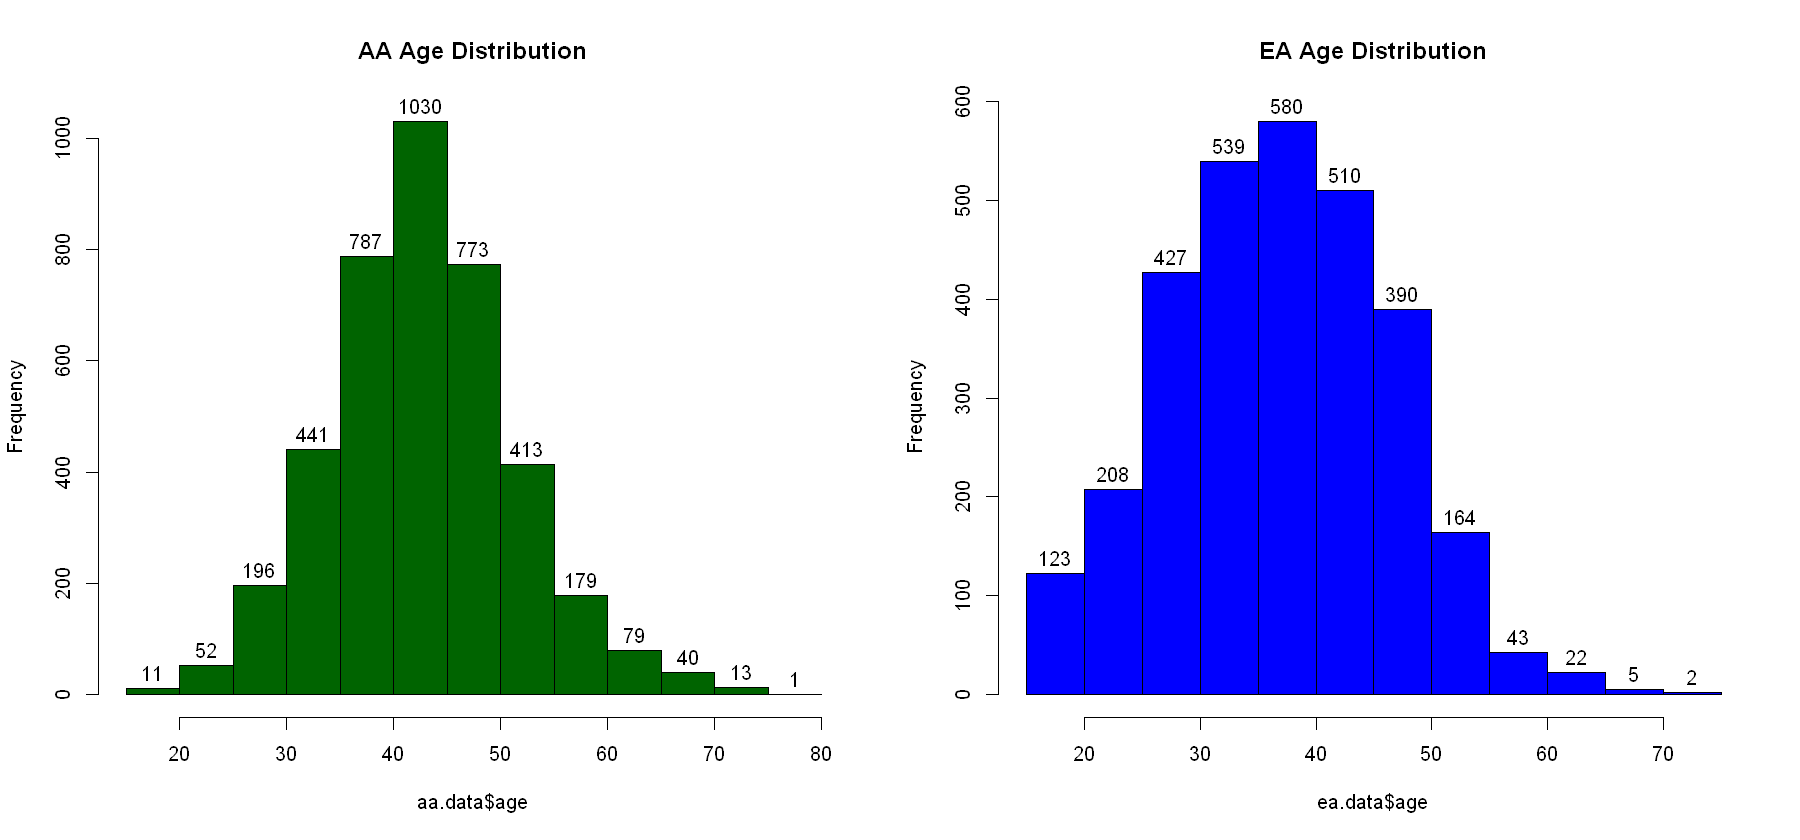

In [103]:
set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
    }
        
set_plot_dimensions(15,7)
par(mfrow=c(1,2))
hist(aa.data$age, col = "dark green", labels = T,
    main="AA Age Distribution")
hist(ea.data$age, col = "blue", labels = T,
    main="EA Age Distribution")

### PCA (EIGENSTRAT)
In the GWAS model, one should control from ancestry substructure. This is achieved by including the top genotype principal component as covariates in the GWAS statistical model. The software EIGENSTRAT can be used to perform the PCA. It is run on LD-pruned observed autosome genotypes for each ancestry group. 
#### Automated Pipeline

In [ ]:
#!/bin/bash

## Set global variables ##
anlist="ea aa" # "ea", "aa", or "ea aa"
study="uhs1234"
case_control="true"  # true if (case control phenotype) false if (not)
genoD="/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/observed" # observed genotype data
procD="/shared/jmarks/hiv/uhs1234/acquisition_gwas/test"  # processing directory
eig="$procD/eig" # do not alter
mkdir -p $eig/results

for an in $anlist;do
    ## rename phenotype file(s) to standard name ##
    current_pheno=$procD/uhs1234_${an}_phenotype_table_clean.txt # edit this line
    new_pheno=$procD/$study_${an}_phenotype_for_pca.txt # don't edit this line
    cp $current_pheno $new_pheno 

    
    ## generate new set of genotype data ##
    genotype_file="${an}_studies_merged" # edit this line
    awk 'NR>=2{print $1,$1}' \
        $current_pheno > $procD/$study.$an.final_ids

    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $genoD/$an/$genotype_file \
        --keep $procD/$study.$an.final_ids \
        --make-bed \
        --out $eig/$study.$an.genotypes

done

# Do not edit below this line
################################################################################
################################################################################


## Remove high-LD region variants ##
for an in $anlist; do
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' \
        $eig/$study.$an.genotypes.bim > $eig/$study.$an.genotypes.high_ld_regions.remove

    # Remove SNPs in known high-LD regions
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes \
        --exclude $eig/$study.$an.genotypes.high_ld_regions.remove \
        --make-bed \
        --out $eig/$study.$an.genotypes.high_ld_regions_removed
done


## Linkage disequilibrium pruning ##
for an in $anlist;do
    for chr in {1..22}; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile $eig/$study.$an.genotypes.high_ld_regions_removed \
            --indep-pairwise 1500 150 0.2 \
            --chr ${chr} \
            --out $eig/${an}_chr${chr}_ld_pruned
    done
done

# Merge *prune.in files
for an in $anlist; do
    cat $eig/${an}_chr*_ld_pruned.prune.in > $eig/${an}_chr_all_ld_pruned.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes.high_ld_regions_removed \
        --extract $eig/${an}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out $eig/$study.$an.genotypes.ld_pruned
done

# Clean up
rm $eig/*ld_pruned.{prune.in,prune.out,log}
rm $eig/*ld_prune*qsub*
rm $eig/*high_ld_regions*
rm $eig/*nosex


## Rename BIM/FAM file IDs
for an in $anlist;do
    # Rename FAM file IDs
    awk '{$1="ID_"NR; $2="ID_"NR; print $0}' $eig/$study.$an.genotypes.ld_pruned.fam \
        > $eig/$study.$an.genotypes.ld_pruned_renamed.fam

    # Rename BIM file IDs
    awk '{$2="ID_"NR; print $0}' $eig/$study.$an.genotypes.ld_pruned.bim \
        > $eig/$study.$an.genotypes.ld_pruned_renamed.bim
done

## Assign Case/Control to FAM file if applicable
if [ $case_control == "true" ]; then
    for an in $anlist; do
        pfile=$procD/$study_${an}_phenotype_for_pca.txt

        ## extract the IDs of controls
        tail -n +2 $pfile |\
            awk '{ if ($2==0) {print $1}}' > $eig/$an.controls.ids

        # Modify FAM file to include case/control status
        awk 'NR==FNR{map[$1] = $1; next} {if($2 in map) {$6=1} else {$6=2}} {print $0} ' \
            $eig/$an.controls.ids $eig/$study.$an.genotypes.ld_pruned_renamed.fam >\
            $eig/$study.$an.genotypes.ld_pruned_renamed_case_control.fam
    done
fi

## run eigenstrat ##
for an in $anlist; do
    if [ $case_control == "true" ]; then
        famfile="$eig/$study.$an.genotypes.ld_pruned_renamed_case_control.fam"
    else
        famfile="$eig/$study.$an.genotypes.ld_pruned_renamed.fam"
    fi
    bimfile="$eig/$study.$an.genotypes.ld_pruned_renamed.bim"
    bedfile="$eig/$study.$an.genotypes.ld_pruned.bed"

    /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i $bedfile \
        -a $bimfile \
        -b $famfile \
        -o $eig/results/${an}_ld_pruned.pca \
        -p $eig/results/${an}_ld_pruned.plot \
        -e $eig/results/${ancestry}_ld_pruned.eval \
        -l $eig/results/${ancestry}_ld_pruned.pca.log \
        -m 0
done


for an in $anlist; do
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 $eig/results/${an}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
done


## Rscript produce the PCA plots
# Rscript myRscript
#

#### Construct subject-filtered PLINK file sets
Generate a new set of genotype data filtered by the phenotype information. Perform LD-pruning on these observed genotype data for the PCA.

In [ ]:
## generate new set of genotype data ##
for an in aa ea; do
    awk 'NR>=2{print $1,$1}' $phenoD/processing/uhs1234_${an}_phenotype_table_clean.txt > \
        $phenoD/processing/$study.$an.final_ids

    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $genoD/$an/${an}_studies_merged \
        --keep $phenoD/processing/$study.$an.final_ids \
        --make-bed \
        --out $eig/$study.$an.genotypes
done

#### Remove high-LD region variants

In [ ]:
## EC2 ##
## Remove high-LD region variants ##
for an in ea aa; do
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }'\
        $eig/$study.$an.genotypes.bim > $eig/$study.$an.genotypes.high_ld_regions.remove
            
    # Remove SNPs in known high-LD regions
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes \
        --exclude $eig/$study.$an.genotypes.high_ld_regions.remove \
        --make-bed \
        --out $eig/$study.$an.genotypes.high_ld_regions_removed
done

 wc -l $eig/*bim
"""
  334333 /shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/eig/uhs1234.aa.genotypes.bim
  327216 /shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/eig/uhs1234.aa.genotypes.high_ld_regions_removed.bim
  326414 /shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/eig/uhs1234.ea.genotypes.bim
  319418 /shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/eig/uhs1234.ea.genotypes.high_ld_regions_removed.bim
"""

#### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of EIGENSTRAT calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
### EC2 console ###

# note only perform on autosomes
for an in ea aa;do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name $study.${an}.chr${chr}.ld_prune \
            --script_prefix $eig/${an}_chr${chr}_ld_prune \
            --mem 3 \
            --nslots 2 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 3000 \
                --bfile $eig/$study.$an.genotypes.high_ld_regions_removed \
                --indep-pairwise 1500 150 0.2 \
                --chr ${chr} \
                --out $eig/${an}_chr${chr}_ld_pruned
    done
done

# Merge *prune.in files
for an in ea aa; do
    cat $eig/${an}_chr*_ld_pruned.prune.in > $eig/${an}_chr_all_ld_pruned.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes.high_ld_regions_removed \
        --extract $eig/${an}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out $eig/$study.$an.genotypes.ld_pruned
done

# Clean up
rm $eig/*ld_pruned.{prune.in,prune.out,log}
rm $eig/*ld_prune*qsub*
rm $eig/*high_ld_regions*
rm $eig/*nosex

wc -l $eig/*bim
""" 
  334333 /shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/eig/uhs1234.aa.genotypes.bim
  172528 /shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/eig/uhs1234.aa.genotypes.ld_pruned.bim
  326414 /shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/eig/uhs1234.ea.genotypes.bim
   98178 /shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/eig/uhs1234.ea.genotypes.ld_pruned.bim
"""

#### Rename BIM/FAM file IDs
Variant IDs in the PLINK `bim` file have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause smartpca to throw an error. To resolve this the IDs are replaced by numeric values. The family IDs in the PLINK `fam` files similarly throw an error in `smartpca` should the number of characters in the IDs be more than 39. For this reason, we will apply an analogous renaming convention.

In [ ]:
# Count ID lengths greater than 39 characters
for an in aa ea; do
    echo -e "\n\n======== ${an} ========\n\n"
    awk '{ if(length($1)+length($2)>39){print $2} }' $eig/$study.$an.genotypes.ld_pruned.fam | wc -l
    awk '{ if(length($2)>39){print $2} }' $eig/$study.$an.genotypes.ld_pruned.bim | wc -l
done

for an in aa ea; do
    # Rename FAM file IDs
    awk '{$1="ID_"NR; $2="ID_"NR; print $0}' $eig/$study.$an.genotypes.ld_pruned.fam \
        > $eig/$study.$an.genotypes.ld_pruned_renamed.fam
    awk '{ if(length($1)+length($2)>39){print $2} }' $eig/$study.$an.genotypes.ld_pruned_renamed.fam | wc -l

#    # Rename BIM file IDs
#    # Make new BIM
#    awk '{$2="ID_"NR; print $0}' $eig/${an}_ld_pruned.bim \
#        > $eig/${an}_ld_pruned_id_renamed.bim
done

**Note** we did not have to rename the bim files for this case.

#### Assign Cases and Controls
Modify the fam file to include case/control status. According to PLINK,

`Phenotype value ('1' = control, '2' = case, '-9'/'0'/non-numeric = missing data if case/control)`

The NGC protocol is consistent with this assignment.

In [ ]:
for an in ea aa; do
    phenofile="uhs1234_${an}_phenotype_table_clean.txt"

    ## extract the IDs of controls 
    tail -n +2 $phenoD/processing/$phenofile |\
        awk '{ if ($2==0) {print $1}}' > $eig/$an.controls.ids

    # Modify FAM file to include case/control status
    awk 'NR==FNR{map[$1] = $1; next} {if($2 in map) {$6=1} else {$6=2}} {print $0} ' \
        $eig/$an.controls.ids $eig/uhs1234.$an.genotypes.ld_pruned_renamed.fam >\
        $eig/uhs1234.$an.genotypes.ld_pruned_renamed_case_control.fam
done

#### Run EIGENSTRAT
__NOTE__: For `smartpca` to run, the BIM and FAM file IDs need to be less than 39 characters in length. Often this is not a problem, but with a BIM file that has IDs renamed to the 1000 Genomes Phase 3 format, the IDs for indels can exceed the character limit. Also, the EIGENSOFT `bin` directory should be part of the PATH variable.

The `smartpca.pl` program documentation is shown below:

DOCUMENTATION of `smartpca.pl` program:

This program calls the smartpca program (see ../POPGEN/README). 
For this to work, the bin directory containing smartpca MUST be in your path. 
See `./example.perl` for a toy example.
```
../bin/smartpca.pl 
-i example.geno  : genotype file in any format (see ../CONVERTF/README)
-a example.snp   : snp file in any format (see ../CONVERTF/README)
-b example.ind   : indiv file in any format (see ../CONVERTF/README)
-k k             : (Default is 10) number of principal components to output
-o example.pca   : output file of principal components.  Individuals removed
                   as outliers will have all values set to 0.0 in this file.
-p example.plot  : prefix of output plot files of top 2 principal components.
                   (labeling individuals according to labels in indiv file)
-e example.eval  : output file of all eigenvalues
-l example.log   : output logfile
-m maxiter       : (Default is 5) maximum number of outlier removal iterations.
                   To turn off outlier removal, set -m 0.
-t topk          : (Default is 10) number of principal components along which 
                   to remove outliers during each outlier removal iteration.
-s sigma         : (Default is 6.0) number of standard deviations which an
                   individual must exceed, along one of topk top principal
           components, in order to be removed as an outlier.

OPTIONAL FLAGS:
-w poplist       : compute eigenvectors using populations in poplist only,
                   where poplist is an ASCII file with one population per line
-y plotlist      : output plot will include populations in plotlist only, 
                   where plotlist is an ASCII file with one population per line
-z badsnpname    : list of SNPs which should be excluded from the analysis
-q YES/NO        : If set to YES, assume that there is a single population and
                   the population field contains real-valued phenotypes.
           (Corresponds to qtmode parameter in smartpca program.)
           The default value for this parameter is NO.

Estimated running time of the smartpca program is 
  2.5e-12 * nSNP * NSAMPLES^2 hours            if not removing outliers.
  2.5e-12 * nSNP * NSAMPLES^2 hours * (1+m)    if m outlier removal iterations.
Thus, under the default of up to 5 outlier removal iterations, running time is 
  up to 1.5e-11 * nSNP * NSAMPLES^2 hours.```

In [ ]:
### EC2 console ###
for ancestry in aa ea; do
    famfile="$eig/uhs1234.$ancestry.genotypes.ld_pruned_renamed_case_control.fam"
    bimfile="$eig/uhs1234.$ancestry.genotypes.ld_pruned.bim"
    bedfile="$eig/uhs1234.$ancestry.genotypes.ld_pruned.bed"

    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name $study.smartpca.$ancestry \
        --script_prefix $eig/results/smartpca.$study.${ancestry} \
        --mem 7.5 \
        --nslots 1 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
            -i $bedfile \
            -a $bimfile \
            -b $famfile \
            -o $eig/results/${ancestry}_ld_pruned.pca \
            -p $eig/results/${ancestry}_ld_pruned.plot \
            -e $eig/results/${ancestry}_ld_pruned.eval \
            -l $eig/results/${ancestry}_ld_pruned.pca.log \
            -m 0
done

#### Extract Eigenvectors

In [ ]:
# Grab top 10 eigenvectors from PCA 
for ancestry in aa ea; do
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $eig/results/${ancestry}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 $eig/results/${ancestry}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> $eig/results/${ancestry}_ld_pruned_top10_eigenvecs.txt
done

#### View PCs from EIGENSTRAT
Copy results over to local machine.

In [ ]:
cd /cygdrive/c/Users/jmarks/Desktop/Projects/HIV/uhs1-4/phenotype/processing/eig
scp -i ~/.ssh/gwas_rsa ec2-user@34.206.166.72:/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/eig/results/*{evec,txt}

In [110]:
### R console ###
# Load PCA data
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/eig/")
options(stringsAsFactors = F)
ea.evec <- read.table("ea_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
aa.evec <- read.table("aa_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
head(ea.evec[,1:5])
head(aa.evec[,1:5])

,V2,V3,V4,V5,V6
ID_1:ID_1,0.0049,0.0022,0.0012,-0.0001,-0.0038
ID_2:ID_2,-0.0127,-0.0280,0.0069,-0.0061,0.0060
ID_3:ID_3,-0.0145,-0.0325,0.0053,-0.0017,-0.0016
ID_4:ID_4,0.0086,0.0034,-0.0009,-0.0022,-0.0033
ID_5:ID_5,0.0071,0.0063,-0.0008,0.0015,0.0010
ID_6:ID_6,-0.0020,-0.0177,-0.0013,0.0004,0.0000


,V2,V3,V4,V5,V6
ID_1:ID_1,0.0012,0.0039,-0.0072,-0.0016,-0.0006
ID_2:ID_2,-0.0140,0.0023,-0.0045,0.0006,0.0086
ID_3:ID_3,-0.0046,0.0004,-0.0009,-0.0030,0.0195
ID_4:ID_4,-0.0151,0.0026,-0.0084,0.0027,0.0042
ID_5:ID_5,-0.0148,0.0055,-0.0024,-0.0005,0.0023
ID_6:ID_6,0.0263,0.0022,-0.0005,-0.0045,-0.0051


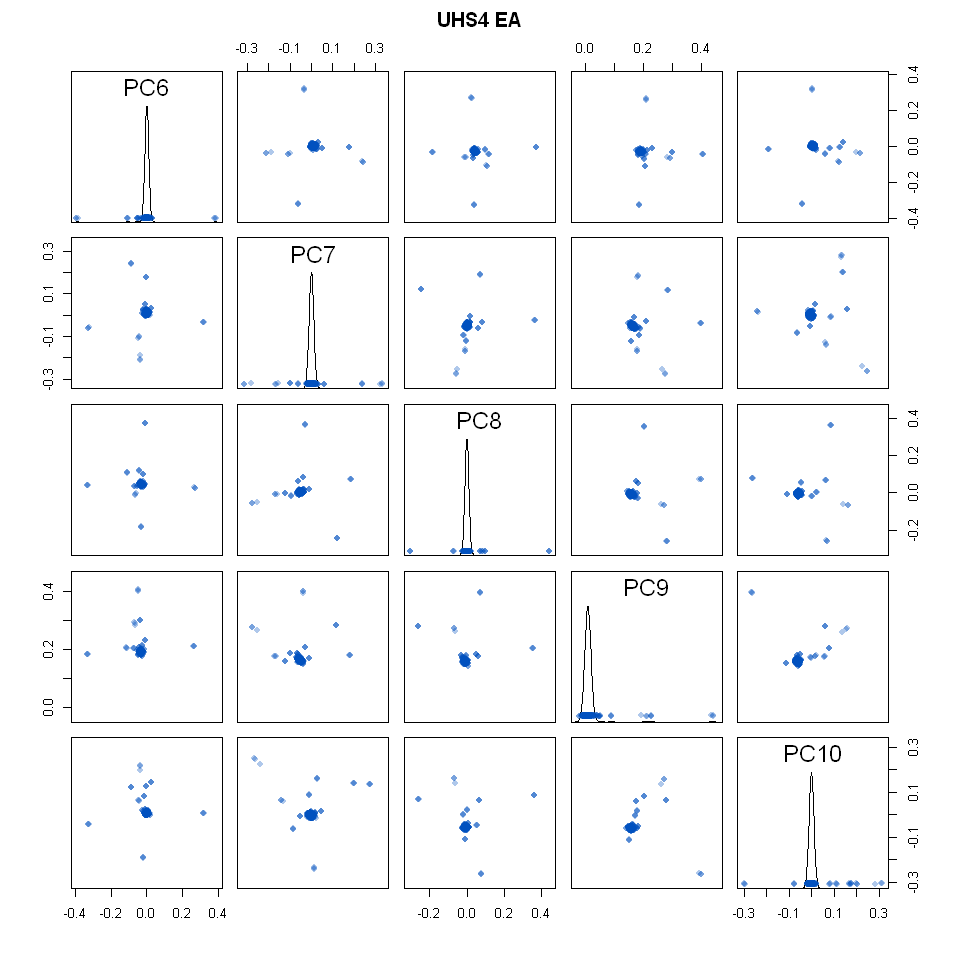

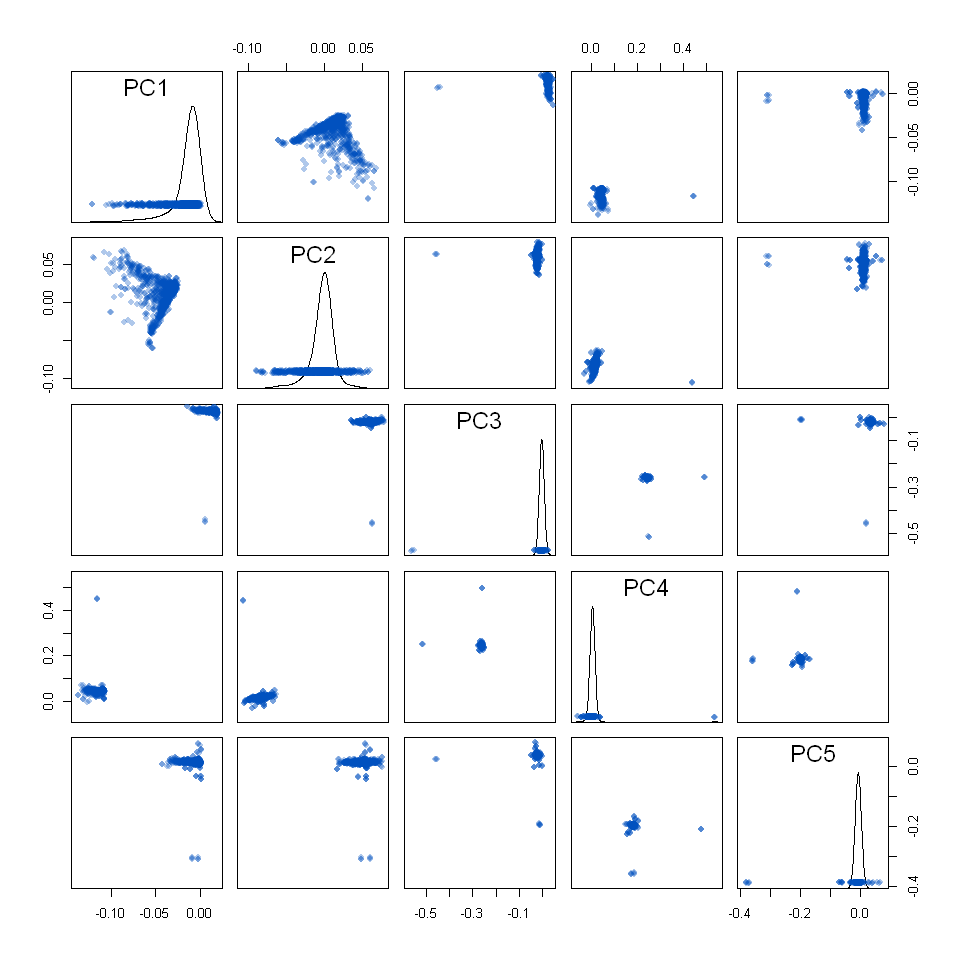

ERROR: Error in plot.xy(xy, type, ...): invalid graphics state


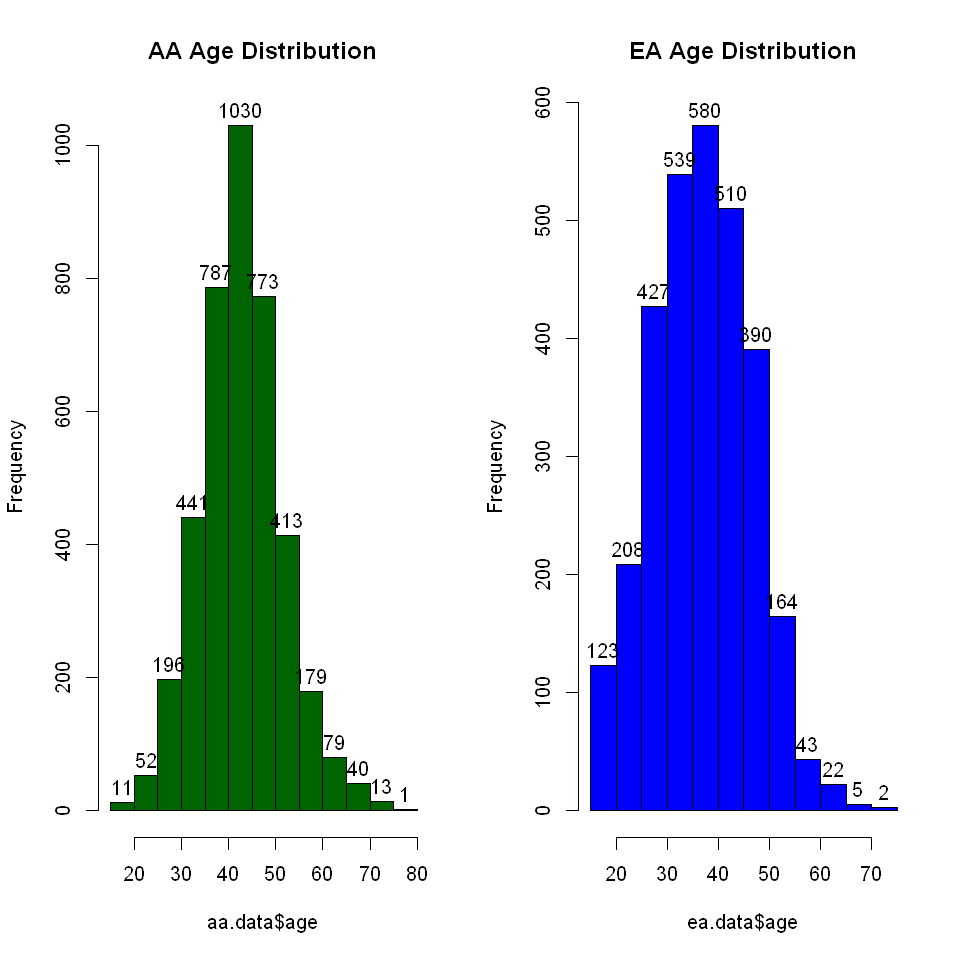

In [113]:
### R console ###
# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

## EA ##
#Run PCA and get % variance
ea.dspace <- ea.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 EA", cex.main=1)


par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 EA", cex.main=1)

## AA ##
#Run PCA and get % variance
aa.dspace <- aa.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 AA", cex.main=1)


par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 AA", cex.main=1)

#### PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance. Make PED format phenotype and covariate file according to the NGC protocol.

##### Create ped file
The GWAS software tool accepts a phenotype file and a covariate file. We will create those files here and refer to them as ped and cov files.

In [114]:
create_pedfile <- function(phen_file, pca_file, phenotype, sex_var, covariates, study, ancestry){
    
    # phenotype file
    pheno_data <- read.delim(phen_file, sep="")
    pca_data <- read.delim(pca_file, sep="")
    other_pedcols <- c("fid", "iid", "patid", "matid", sex_var)
    ped_width <- length(other_pedcols) + length(phenotype)
    ped_length <- nrow(pheno_data)
    ped_file <- data.frame(matrix(ncol=ped_width, nrow=ped_length))
    colnames(ped_file) <- c(other_pedcols, phenotype)
    ped_file[phenotype] <- pheno_data[phenotype]
    ped_file[sex_var] <- pheno_data[sex_var]
    ped_file["fid"] <- pheno_data[1]
    ped_file["iid"] <- pheno_data[1]
    # covariate file
    num_cols <- 14 + length(covs)
    covar_data <- data.frame(matrix(ncol=num_cols, nrow=ped_length))
    colnames(covar_data) <- c("fid", "iid", "patid", "matid", covs,
                             "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
    covar_data[,1:4] <- ped_file[, 1:4]
    for (i in covs){
        covar_data[,i] <- pheno_data[,i]
    }
    
    covar_data[, (num_cols-9):num_cols] <- pca_data[,3:12]
    write.table(ped_file, paste(study,"_", ancestry, "_phen.ped", sep=""), sep = "\t", row.names = F, quote=F)
    write.table(covar_data, paste(study,"_", ancestry, "_cov.ped", sep=""), sep = "\t", row.names = F, quote=F)
    head(ped_file)
    #head(covar_data)
    
    } # end function

#### Regression analysis
We use a regression model of the general structure:

$Phenotype = PC1 + PC2 + ... + PC10$

In [115]:
regression_analysis <- function(cov_file, phen_file, phenotype_name, model_type, ancestry){
    options(stringsAsFactors=F)
    
    cov_data <- read.delim(cov_file, sep="")
    phen_data <- read.delim(phen_file, sep="")
    pc_names <- paste0("PC", 1:10)
    merge_data <- merge(x=phen_data[,c("iid", phenotype_name)], y=cov_data[, c("iid", pc_names)], by="iid")
    
    model.str <- paste0(phenotype_name, "~", paste(pc_names, collapse=" + ")) 
    cat("MODEL FORMULA:\n\n", model.str, "\n")
    
    # Get model fits
    if (model_type=="continuous"){
        model_fit <- lm(formula=as.formula(model.str), data=merge_data)
        pve_calc <- "Mean Sq"
    }
    else if (model_type=="logistic"){
        model_fit <- glm(formula=as.formula(model.str), data=merge_data, family=binomial(link="logit"))
        pve_calc <- "Deviance"
    }
    
    # Get sequential (type I) sum of squares
    anova_model <- anova(model_fit)
    
    # Calculate percent variance explained and sort
    variance_explained <- cbind(anova_model[pc_names,], 
                    PVE=round(anova_model[pc_names, pve_calc]/sum(anova_model[pc_names, pve_calc])*100, digits=2))
    pve_sorted <- variance_explained[order(variance_explained$PVE, decreasing=T),]
    
    # Output regression info
    cat(paste("\n\n================", ancestry,  "group ================\n"))
    summary(model_fit)
    pve_sorted
    
    # Percent Variance Explained Visualization
    options(repr.plot.width=13, repr.plot.height=5)

    # Set graphical parameters
    cex.factor <- 0.9
    barplot_ylim <- c(0, max(variance_explained$PVE)*1.2)

    pv_list <- vector(length = 10)
    total <- 0
    for (i in 1:nrow(pve_sorted)){
        pv_list[i] <- row.names(pve_sorted[i,])
        total <- total + pve_sorted[i, "PVE"]
        #print(total)
        if (total >= 75) break
    }

    topPCs <- pv_list[which(pv_list != "FALSE")]
    cat("Top PCs: ",topPCs, "\n")
    cat(paste("PVE:     ", total))

    # Visualize PVE
    par(mfrow=c(1,2))
    barplot(height=variance_explained$PVE, names.arg=rownames(variance_explained), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, 
            main=paste(ancestry,"Percent Variance Explained"), ylab="PVE")
    plot(cumsum(variance_explained$PVE), type="b", main=paste(ancestry, "PVE Cumulative Sum"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(variance_explained), cex.axis=cex.factor)

    par(mfrow=c(1,2))
    barplot(height=pve_sorted$PVE, names.arg=rownames(pve_sorted), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, main=paste(ancestry,"Percent Variance Explained (Sorted PCs)"), ylab="PVE")
    plot(cumsum(pve_sorted$PVE), type="b", main=paste(ancestry,"PVE Cumulative Sum (Sorted PCs)"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(pve_sorted), cex.axis=cex.factor)
}

##### AA

fid,iid,patid,matid,gender,hiv
109@1064714572,109@1064714572,NA,NA,1,0
202@1064714531,202@1064714531,NA,NA,0,0
312@1064714548,312@1064714548,NA,NA,1,0
378@1064610814,378@1064610814,NA,NA,1,0
432@1064714492,432@1064714492,NA,NA,1,0
456@1064714691,456@1064714691,NA,NA,1,0


MODEL FORMULA:

 hiv~PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ AFR group ================
Top PCs:  PC10 PC9 PC2 PC6 
PVE:      81.81

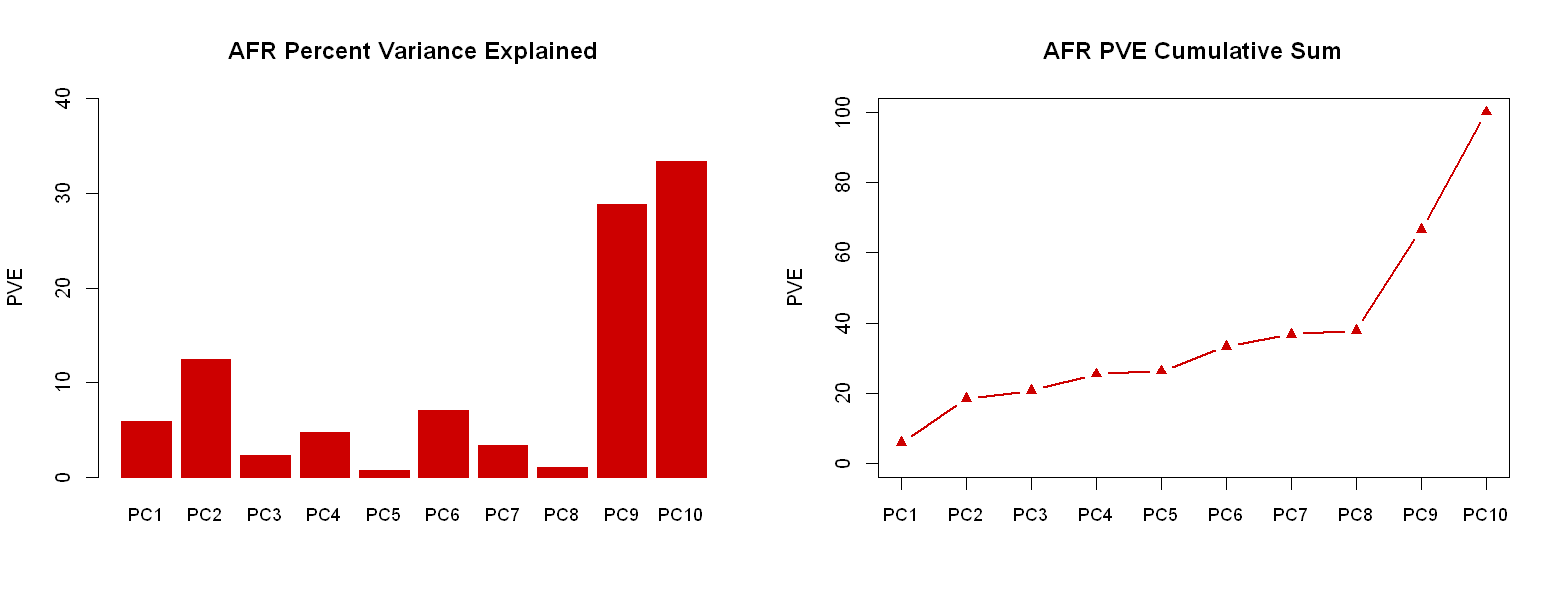

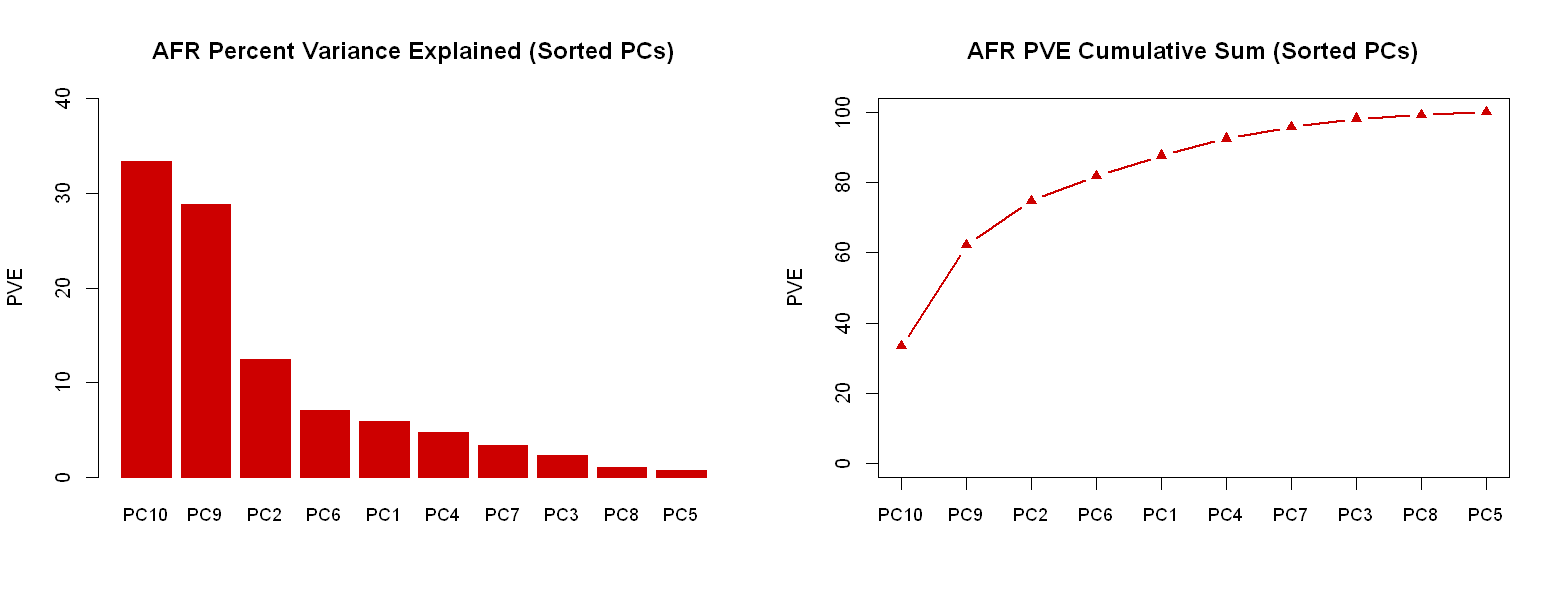

In [116]:
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/")
study <- "UHS1234"
ancestry <- "AFR" # EUR or AFR
phenotype <- "hiv"
sex_var <-  "gender"
covs <- c(sex_var, "age")
phen_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/uhs1234_aa_phenotype_table_clean.txt"
pca_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/eig/aa_ld_pruned_top10_eigenvecs.txt"
model_type <- "logistic" # continuous or logistic

cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)

##### EA

fid,iid,patid,matid,gender,hiv
260524@1054753970,260524@1054753970,NA,NA,0,0
245@1064714500,245@1064714500,NA,NA,1,0
266@1064714555,266@1064714555,NA,NA,1,0
441@1064714760,441@1064714760,NA,NA,1,0
541@1064714713,541@1064714713,NA,NA,1,0
564@1064612881,564@1064612881,NA,NA,0,0


MODEL FORMULA:

 hiv~PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ EUR group ================
Top PCs:  PC1 PC9 PC10 
PVE:      82.11

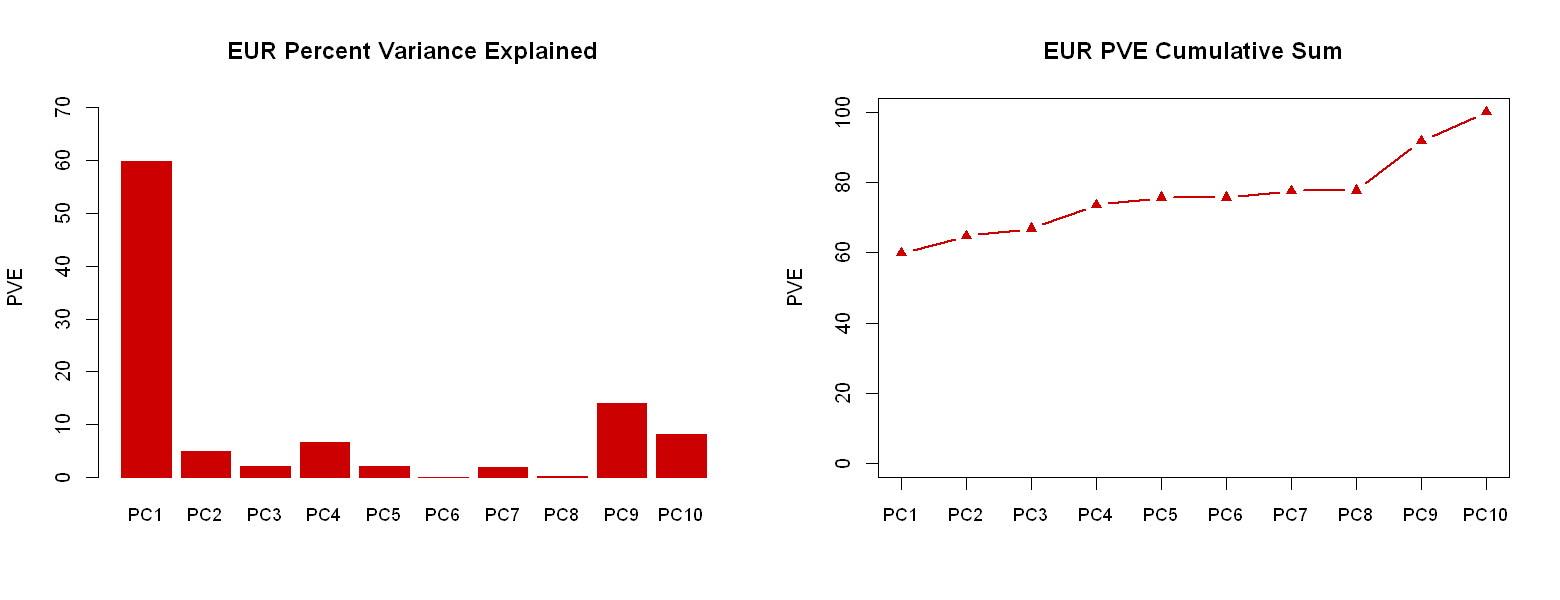

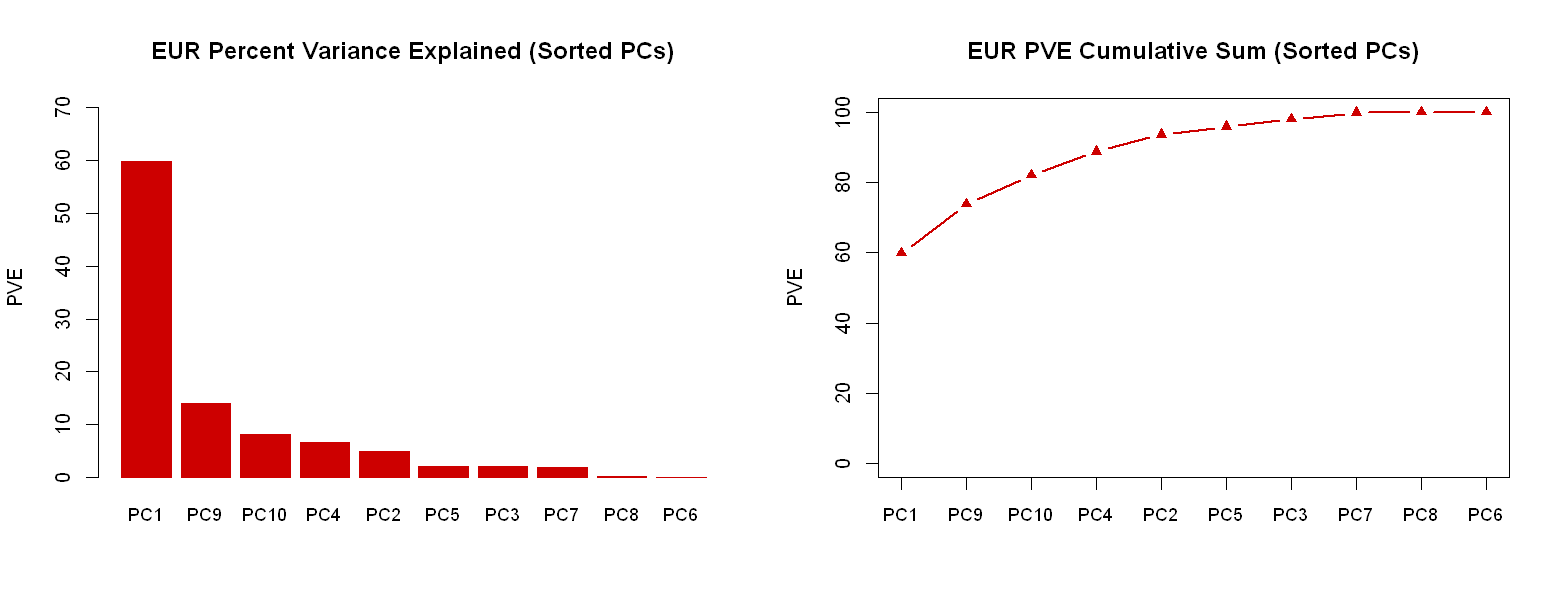

In [117]:
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/")
study <- "UHS1234"
ancestry <- "EUR" # EUR or AFR
phenotype <- "hiv"
sex_var <-  "gender"
covs <- c(sex_var, "age")
phen_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/uhs1234_ea_phenotype_table_clean.txt"
pca_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/eig/ea_ld_pruned_top10_eigenvecs.txt"
model_type <- "logistic" # continuous or logistic

cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)

### Alter iid to match imputed data
The IDs in the genotype (imputed data) are of the form `fid_iid`. Therefore, I need to map the iid in the PED files to this format.

In [ ]:
## Bash ##
study=UHS1234

# AA
awk '{OFS="_"} { print $2,$2 } ' ${study}_AFR_phen.ped > new_id
awk 'NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]} { print $0}' \
    new_id ${study}_AFR_phen.ped > ${study}_NGCW1_AFR_phen.ped
awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR] } {print $0}' \
    new_id ${study}_AFR_cov.ped > ${study}_NGCW1_AFR_cov.ped


# EA
awk '{OFS="_"} { print $2,$2 } ' ${study}_EUR_phen.ped > new_id
awk 'NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]} { print $0}' \
    new_id ${study}_EUR_phen.ped > ${study}_NGCW1_EUR_phen.ped
awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR] } {print $0}' \
    new_id ${study}_EUR_cov.ped > ${study}_NGCW1_EUR_cov.ped

scp -i ~/.ssh/gwas_rsa *NGCW1* ec2-user@34.206.166.72:/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing

### ProbABEL format for phenotype file
The format of the phenotype thus far has follows the protocol of the NGC protocol, and therefore the phenotype file format is prepared for RVTESTS. Since we are using the ProbABEL software for these analysis we will format the phenotype file to be of the  form:
```
IID    PHENOTYPE    OTHER_COVARIATES
```
where `OTHER_COVARIATES` could be sex, age, PCs, etc. 

**Note:**

**additional phenotype processing will have to be done once the genotype data are processed.** In particular, we will:
1. First get the IDs of the samples in the phenotype file.
2. Then we will filter the genotype (imputed) data down to those subjects in the phenotype file.
3. We will get the order of the subjects in the genotype data and then reorder our phenotype data to be the same order
    * this is more efficient than trying to reorder every genotype file.

Also take note about the coding of case/control status, as well as other binary variables in the phenotype file. The ProbABEL software dictates that the binary phenotype variable is to be coded as 0s & 1s, presumably control=0, case=1. We should code the sex variable to this standard as well.

In [ ]:
probabel_phenotype <- function(cov_file, pheno_file, study, pop, pcs, other_covs, pheno){
    #Convert your phenotype PED files (as required for rvtests) to the
    #ProbABEL format.
    
    pc_paste <- paste(pcs, collapse="+")
    othercov_paste <- paste(other_covs, collapse="_")
    out_name <- paste(study, pop, pheno, othercov_paste, pc_paste, sep="_")
    out_name <- paste0(out_name, ".txt")

    all_covs <- c(other_covs, pcs)

    # read in data files
    my_cov <- read.table(cov_file, header=T)
    my_pheno <- read.table(pheno_file, header=T)

    num.subjects <- length(my_cov[,1])

    # create new phenotype file (dataframe)
    num_cols = 2 + length(other_covs) # iid + pheno + covs
    covar.data <- data.frame(matrix(ncol = num_cols, nrow = num.subjects))
    names(covar.data) <- c("iid", pheno, other_covs)
    covar.data[1] <- my_pheno[,"iid"]
    covar.data[2] <- my_pheno[, pheno]

    for (cov in all_covs){
        covar.data[, cov] <- my_cov[,cov]
    }
    #head(covar.data)

    write.table(x = covar.data, file = out_name, quote = F, row.names = F)
    write.table(x = covar.data[,1], file = paste0("phenotype_ids_", pop), 
                quote = F, row.names = F, col.names=F)
}

#### EA and AA
Convert phenotype file for both EA and AA to probabel format

In [ ]:
### R ###
setwd("/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/final")

## A
cov_file <- "../processing/UHS1234_NGCW1_AFR_cov.ped"
pheno_file <- "../processing/UHS1234_NGCW1_AFR_phen.ped"
study <- "uhs1234"
pop <- "aa"
pcs = c("PC10", "PC9", "PC2", "PC6")
other_covs <- c("age", "gender")
pheno <- "hiv"
probabel_phenotype(cov_file, pheno_file, study, pop, pcs, other_covs, pheno)


## EA
cov_file <- "../processing/UHS1234_NGCW1_EUR_cov.ped"
pheno_file <- "../processing/UHS1234_NGCW1_EUR_phen.ped"
study <- "uhs1234"
pop <- "ea"
pcs = c("PC1", "PC9", "PC10")
other_covs <- c("age", "gender")
pheno <- "hiv"
probabel_phenotype(cov_file, pheno_file, study, pop, pcs, other_covs, pheno)

## Genotype Data
Prepare Genotype Data for analysis software.
1. Inflate imputation results
    * These data were imputed on the Michigan Imputation Server and therefore need to be inflated.
2. Merge chrX
    * The chrX imputed data from the Michigan Imputation Server is split between males and females. We need to merge these data for the GWAS because the other data is not split by sex. We control for that with a sex covariate.
3. Convert imputed data format
    * The ProbABEL software requires the data to be formatted differently than the VCF format that is the output from MIS. In particular, we need to convert the VCF files (dosage) to MaCH format.
4. Prune imputed data
    * Prune the imputed data to only the subjects with phenotype data
5. Reorder phenotype file 
    * order the subjects in phenotype file to be the same order as the genotype data (takes less memory to reorder the phenotype file rather than all of the genotype files)
6. Create legend file
7. Reformat info file

In [ ]:
## bash script ##
chr=$1  # command line argument (chromosome number)

ancestry="aa"
version="001"  # gwas attempt/version
study="uhs1234"
probabel="palogist" # palogist (logistic) or palinear (linear)
model="1df" # 1df(one degree of freedom) or 2df (two degrees of freedom)
covars="sex,age,PC10,PC9,PC2,PC6"
MODEL="HIV_ACQ~SNP+AGE+SEX+PC10+PC9+PC2+PC6" # phenotype~SNP+COV1+COV2+...+COVN+PC1+PC2+...+PCN
imputeD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/$ancestry
# list of ids extracted from the phenotype file 
pheno_order=/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/final/phenotype_ids_${ancestry}
phenotype_file=/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/final/uhs1234_aa_hiv_age_gender_PC10+PC9+PC2+PC6.txt
# path to the order of the subject IDs in the pruned genotype files (output from reording genotype files with python script)
id_order=/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/$ancestry/mach/chr$chr/chr$chr.genotype.id.order  
#dose_suffix="mach.dose.filtered"
#info_suffix="mach.pruned.info"

genD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/$ancestry/mach
procD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/gwas/$model/$ancestry/$version
phenD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/final
mkdir -p $procD/final
mkdir -p $procD/processing/chr$chr


####################################################################################################
####################################################################################################
main() {
    
    merge_chrx $chr 
    convert_chrx 
    convert_auto $chr
    create_legend $chr
    format_info $chr
    prune_geno $chr $imputeD/mach/chr$chr $pheno_order
    reorder_auto
    reorder_chrx
    gwas_auto
    gwas_chrx
    
}
####################################################################################################
####################################################################################################

# merge chrx male & female data
merge_chrx() {
    echo "Starting merge_chrx function for chr$chr"
        /shared/bioinformatics/software/third_party/bcftools-1.6/bcftools merge \
            $imputeD/chrX.no.auto_male.dose.vcf.gz $imputeD/chrX.no.auto_female.dose.vcf.gz \
            -O z -o $imputeD/chrX.no.auto.dose.vcf.gz
    
    echo ""
    echo "merge_chrx function complete for chr$chr"
    echo ""
}

# convert chrx data to ProbABEL acceptable format
convert_chrx() {
    echo "Starting convert_chrx function for chr$chr"
    chr=23
    chr_location=$imputeD/mach/chr${chr}
    mkdir -p $chr_location
    /shared/bioinformatics/software/third_party/dosage_converter_v1.0.4/bin/DosageConvertor \
        --vcfDose $imputeD/chrX.no.auto.dose.vcf.gz \
        --prefix ${chr_location}/chr${chr} \
        --type mach \
        --format 1 # contains the expected alternate allele count (one value per sample per marker).
    echo ""
    echo "convert_chrx function complete for chr$chr"
    echo ""
}

# convert autosomal data to ProbABEL acceptable format
convert_auto() {
    echo "Starting convert_auto function for chr$chr"
    chr=$1
    chr_location=$imputeD/mach/chr$chr
    mkdir -p $chr_location
    /shared/bioinformatics/software/third_party/dosage_converter_v1.0.4/bin/DosageConvertor \
        --vcfDose $imputeD/chr$chr.dose.vcf.gz \
        --info $imputeD/chr$chr.info.gz \
        --prefix $chr_location/chr$chr \
        --type mach \
        --format 1 # contains the expected alternate allele count (one value per sample per marker).
    
    echo ""
    echo "convert_auto function complete for chr$chr"
    echo ""
}


# create legend file for ProbABEL
create_legend() {
    echo "Starting create_legend function for chr$chr"
    chr=$1
    # HapMap "legend" file format
    # note that our data is not in rsID format - we have chr:position for the rsID instead
    echo "id position 0 1" > $imputeD/mach/chr$chr/map.chr$chr.legend
    # grab the SNP, position, allele1 and allele2
    tail -n +2 $imputeD/mach/chr$chr/*info |\
    awk '{pos = $1; gsub(/^.+:/, "", pos); print $1,pos,$2,$3}' >>\
    $imputeD/mach/chr$chr/map.chr$chr.legend
    echo ""
    echo "create_legend function complete for chr$chr"
    echo ""
}

# format the info file for ProbABEL
format_info() {
    echo "Starting format_info function for chr$chr"
    chr=$1
    cut -f 1-7 $imputeD/mach/chr${chr}/chr${chr}.mach.info >\
        $imputeD/mach/chr$chr/chr$chr.mach.pruned.info  \
    echo ""
    echo "format_info function complete for chr$chr"
    echo ""
}

# prune the genotype data
prune_geno() {
    echo "Starting prune_geno function for chr$chr"
    chr=$1 
    baseD=$2
    idL=$3
    python ~/bin/prune_genotype_files.py $chr $baseD $idL
    echo ""
    echo "prune_geno function complete for chr$chr"
    echo ""
}

# reorder phenotype file for autosomal data
reorder_auto() {
    echo "Starting reorder_auto function for chr$chr"
    phenoF=${phenotype_file::-4}_ordered.txt
    head -1 $phenotype_file > $phenoF
    awk 'FNR==NR {x2[$1] = $0; next} $1 in x2 {print x2[$1]}' \
        $phenotype_file $id_order >> $phenoF # id_order comes from file from prune_geno function
    echo ""
    echo "reorder_auto function complete for chr$chr"
    echo ""
}

# reorder phenotype file for chrX
reorder_chrx() {
    echo "Starting reorder_chrx function for chr$chr"
    phenoFX=${phenotype_file::-4}_ordered_chrx.txt
    head -1 $phenotype_file > $phenoFX
    awk 'FNR==NR {x2[$1] = $0; next} $1 in x2 {print x2[$1]}' \
        $phenotype_file $id_order >> $phenoFX # id_order comes from file from prune_geno function
    echo ""
    echo "reorder_chrx function complete for chr$chr"
}


## perform GWAS (logistic)
gwas_auto() {
    echo "Starting gwas_auto function for chr$chr"
    /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
        --pheno $phenD/$phenoF \ 
        --dose  $genD/chr$chr/chr$chr.mach.dose.pruned \
        --info  $genD/chr$chr/chr$chr.mach.info.pruned \
        --map   $genD/chr$chr/map.chr$chr.legend \
        --chrom $chr \
        --out   $procD/processing/chr$chr/chr$chr.$probabel.results
    echo ""
    echo "gwas_auto function complete for chr$chr"
}

gwas_chrx(){
    chr=23
    # chrx has a different order phenotype file because the dose file is ordered by sex
    time /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
        --pheno $phenD/$phenoXF \  
        --dose  $genD/chr$chr/chr$chr.mach.dose.pruned \
        --info  $genD/chr$chr}/chr$chr.mach.info.pruned \
        --map   $genD/chr$chr/map.chr$chr.legend \
        --chrom $chr \
        --out   $procD/processing/chr$chr/chr$chr.$probabel.results
}

####################################################################################################
####################################################################################################
time main $1  # $1 is chromosome, 

In [ ]:
## run gwas ##
cd /shared/jmarks/hiv/uhs1234/acquisition_gwas/gwas/
#for chr in {1..23};do
chr=14
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name bmerge \
    --script_prefix ${imputedir}/bmerge \
    --mem 7.5 \
    --nslots 7 \
    --priority 0 \
    --program bash gwas_pipeline.sh $chr

In [ ]:
for an in ea aa; do
    imputedir=/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/$an
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name bmerge \
        --script_prefix ${imputedir}/bmerge \
        --mem 7.5 \
        --nslots 2 \
        --priority 0 \
        --program "/shared/bioinformatics/software/third_party/bcftools-1.6/bcftools merge \
            ${imputedir}/chrX.no.auto_male.dose.vcf.gz ${imputedir}/chrX.no.auto_female.dose.vcf.gz \
            -O z -o ${imputedir}/chrX.no.auto.vcf.gz"
done

### Convert format: dose to mach
The ProbABEL software requires the data to be formatted differently than the VCF format that is the output from MIS. In particular, we need to convert the VCF files (dosage) to MaCH format.

In [ ]:
ancestry=aa
base_dir=/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/$ancestry

# autosomes
#for chr in {1..22};do
chr=10
    chr_location=${base_dir}/mach/chr$chr
    mkdir -p $chr_location

    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name convert_dosage_chr${chr} \
        --script_prefix $chr_location/chr${chr}.convert \
        --mem 10 \
        --buffer 100000 \
        --nslots 7 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/dosage_converter_v1.0.4/bin/DosageConvertor \
            --vcfDose ${base_dir}/chr${chr}.dose.vcf.gz \
            --info ${base_dir}/chr${chr}.info.gz \
            --prefix $chr_location/chr${chr} \
            --type mach \
            --format 1 # contains the expected alternate allele count (one value per sample per marker).
done

# chrX
chr=23
base_dir=/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/aa
chr_location=${base_dir}/mach/chr${chr}
mkdir -p $chr_location
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name convert_dosage_chr${chr} \
    --script_prefix ${chr_location}/chr${chr}.convert \
    --mem 10 \
    --buffer 100000 \
    --nslots 7 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/dosage_converter_v1.0.4/bin/DosageConvertor \
        --vcfDose ${base_dir}/chrX.no.auto.dose.vcf.gz \
        --prefix ${chr_location}/chr${chr} \
        --type mach \
        --format 1 # contains the expected alternate allele count (one value per sample per marker).

#### chrX info file
**Note:** about chrX. When you convert the dosage file from vcf to mach, the info files from male/female are not accurate for variants in terms of AF and quality, so I did not use info file in Dosage_Converter. Instead I calculated these AF after GWAS by taking into account both the male and female AFs. The quality score I reported in both genders.

```css
The info file generated by minimac3/4 at the same time as the VCF dosage file
(This parameter is optional, but if NO info file is provided, the output MaCH info file will have missing columns.)
```

female unique SNPs (18):
```
X:48797086      C       T       0.00877 0.00877 -       -       Typed_Only      -       -       -       -       -
X:53460906      C       T       0.00219 0.00219 -       -       Typed_Only      -       -       -       -       -
X:59063483      T       C       0.11842 0.11842 -       -       Typed_Only      -       -       -       -       -
X:59099494      T       C       0.00439 0.00439 -       -       Typed_Only      -       -       -       -       -
X:59134135      A       G       0.00219 0.00219 -       -       Typed_Only      -       -       -       -       -
X:59178058      T       C       0.00439 0.00439 -       -       Typed_Only      -       -       -       -       -
X:59189481      A       G       0.03728 0.03728 -       -       Typed_Only      -       -       -       -       -
X:59213338      G       A       0.00658 0.00658 -       -       Typed_Only      -       -       -       -       -
X:59251895      G       A       0.06360 0.06360 -       -       Typed_Only      -       -       -       -       -
X:59262486      C       A       0.00219 0.00219 -       -       Typed_Only      -       -       -       -       -
X:59282717      G       A       0.01316 0.01316 -       -       Typed_Only      -       -       -       -       -
X:59332968      T       C       0.01974 0.01974 -       -       Typed_Only      -       -       -       -       -
X:63091629      C       A       0.00219 0.00219 -       -       Typed_Only      -       -       -       -       -
X:70625141      T       C       0.00219 0.00219 -       -       Typed_Only      -       -       -       -       -
X:88685058      C       T       0.00658 0.00658 -       -       Typed_Only      -       -       -       -       -
X:128778535     C       T       0.00658 0.00658 -       -       Typed_Only      -       -       -       -       -
X:134303025     C       A       0.00658 0.00658 -       -       Typed_Only      -       -       -       -       -
X:134315090     C       T       0.00658 0.00658 -       -       Typed_Only      -       -       -       -       -
```

male unique SNPs (8):
```
X:48349873      G       A       0.00140 0.00140 -       -       Typed_Only      -       -       -       -       -
X:48772479      C       T       0.00141 0.00141 -       -       Typed_Only      -       -       -       -       -
X:50058760      A       G       0.00143 0.00143 -       -       Typed_Only      -       -       -       -       -
X:70330483      C       T       0.00140 0.00140 -       -       Typed_Only      -       -       -       -       -
X:75651394      T       C       0.00141 0.00141 -       -       Typed_Only      -       -       -       -       -
X:101857367     C       T       0.00140 0.00140 -       -       Typed_Only      -       -       -       -       -
X:153230408     G       A       0.00281 0.00281 -       -       Typed_Only      -       -       -       -       -
X:153629663     C       T       0.00140 0.00140 -       -       Typed_Only      -       -       -       -       -
```

These were `genotyped-only` SNPs. When we create the info file, we will either exclude these 18 SNPs or handle them separately when we merge the male and female data.

### Prune mach files 

The converted genotype data (mach format) files need to be reorder and pruned to match the subjects in the phenotype file. 
Pg. 7 of the [ProbABEL manual](http://www.genabel.org/sites/default/files/pdfs/ProbABEL_manual.pdf) reports that the genomic predictor file—which is the dosage file—has in the first column a sequential ID, followed by an arrow followed by the study ID.

We will first get a list of the IDs from the phenotype file.

In [ ]:
## python ##
"""
processing.genotype.files.py

This script will process the mach.dose genotype files.
In particular, it will remove any subjects that are not
the phenotype file. It will output the new filtered mach.dose
file as well as a file that contains the order of the subject
IDs in the genotype files. We will then use this information to
reorder the phenotype file.

input: chrom name_of_order_file

where chrom is the chromosome to process and name_of_order_file is the 
output name of the file that contains the order of the samples in the genoytpe data
"""
import gzip, sys, os

os.chdir("/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/aa/mach")

chrom = sys.argv[1]

print(chrom)
myfile = "chr{0}/chr{0}.mach.dose.gz".format(chrom)
keep_ids = "/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/final/phenotype_ids_aa" # list of ids extracted from the phenotype file
outfile = "chr{0}/chr{0}.mach.dose.pruned".format(chrom)
out_order = "chr{0}/chr{0}.genotype.id.order".format(chrom)

with gzip.open(myfile) as inF, open(keep_ids) as sexF, open(outfile, 'w') as outF, open(out_order, "w") as outID:
    sex_set = set()
    for line in sexF:
        sex_set.add(line.strip())

    line = inF.readline()
    count = 1
    while line:
        sl = line.split()
        gen_id = sl[0].split("->")[0]
        if gen_id in sex_set:
            sl[0] = "{}->{}".format(count, gen_id)
            count += 1
            newline = " ".join(sl)
            outF.write(newline + "\n")
            outID.write(gen_id + "\n")

        line = inF.readline()

    message = "chr{0} all done!".format(chrom)
    print(message)

In [ ]:
## bash ##
cd /shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/aa/mach
# autosomes
#11..14};do
chr=10
    /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name chr$chr.gen.data.processing \
            --script_prefix chr$chr/chr${chr}_mach_formatting \
            --mem 20 \
            --nslots 3 \
            --program time python processing.genotype.files.py $chr 
done

Remove mach.dose.gz files once finished (not the mach.dose.filtered) to save storage space because these imputed data can become quite large.

### Reorder phenotype file
Reorder the phenotype file to be of the same order as the genotype files. 

**Note** the autosomes and chrX will have different orders and will therefore require different phenotype files. This is because chrX is imputed separately for males and females on the Michigan Imputation Server. We have to merge the data after we get them which results in the genotype data being in a disparate order than the autosomes. It might be handier if we just reorder chrX genotype file to be the same order as the autosomes so that we don't have to have to different phenotype files.

In [ ]:
cd /shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/final

ln -s /shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/aa/mach/chr22/chr22.genotype.id.order ./aa_genotype_id_order
#ln -s /shared/jmarks/hiv/vidus/genotype/impute/final/ea/mach/chr23/order.of.genotype.ids.chrx .



## AA
# autosomes
head -1 uhs1234_aa_hiv_age_gender_PC10+PC9+PC2+PC6.txt >\
    uhs1234_aa_hiv_age_gender_PC10+PC9+PC2+PC6_ordered.txt
awk 'FNR==NR {x2[$1] = $0; next} $1 in x2 {print x2[$1]}' \
    uhs1234_aa_hiv_age_gender_PC10+PC9+PC2+PC6.txt aa_genotype_id_order >>\
    uhs1234_aa_hiv_age_gender_PC10+PC9+PC2+PC6_ordered.txt

# chrX
#head -1 vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.txt >\
#    vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.chrx.txt
#awk 'FNR==NR {x2[$1] = $0; next} $1 in x2 {print x2[$1]}' \
#    vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.txt order.of.genotype.ids.chrx >>\
#    vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.chrx.txt


## EA

### create legend
Pg. 10 of the [ProbABEL manual](http://www.genabel.org/sites/default/files/pdfs/ProbABEL_manual.pdf) reports that the legend should be in HapMap format:

rsID, position, allele1, allele2

Note: We do not have the rsID right now. We have the chromosome and the position. It shouldn't be to difficult to convert this to the actual rsID. We might be able to use Nathan Gladdis' Nyholt script to convert these. This can be converted later, though. Also, this is an optional file. The only column that is actually used is the SNP location.

In [ ]:
## EC2 console ##
an="aa"
machD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/$an/mach

# HapMap "legend" file format
# note that our data is not in rsID format - we have chr:position for the rsID instead
#for chr in {1..23}; do
chr=23
    # print header
    echo "id position 0 1" > $machD/chr$chr/map.chr$chr.legend
    # grab the SNP, position, allele1 and allele2
    tail -n +2 $machD/chr${chr}/*info | awk '{pos = $1; gsub(/^.+:/, "", pos); print $1,pos,$2,$3}' >>\
        $machD/chr$chr/map.chr$chr.legend
done &

### Format info file
The ProbABEL manual specifies that the info file should have exactly 7 columns.

In [ ]:
## bash ##
for chr in {1..23}; do
    cut -f 1-7 $machD/chr${chr}/chr${chr}.mach.info > $machD/chr$chr/chr$chr.mach.pruned.info & \
    wait
done &

# Start ProbABEL Analysis (logistic model)
Perform GWAS. Consult [ProbABEL manual](http://www.genabel.org/sites/default/files/pdfs/ProbABEL_manual.pdf) for details about software parameters.

| Ancestry | cases | controls | Total |
|----------|-------|----------|-------|
| EUR      |  348  | 2,665    | 3,013 |
| AFR      |  627  | 3,388    | 4,015 |   
  

## AA Baseline GWAS
PC10+PC9+PC2+PC6

**Note**: will have to use a compute node with very large memory (e.g. x1e.2xlarge)

In [ ]:
## create directory structure 
version="001" 
study="uhs1234"
model="1df"
MODEL="HIV_ACQ~SNP+AGE+SEX+PC10+PC9+PC2+PC6"
covars="sex,age,PC10,PC9,PC2,PC6"
ancestry="aa"
phenoF="uhs1234_aa_hiv_age_gender_PC10+PC9+PC2+PC6.txt"
phenoXF=""
dose_suffix="mach.dose.pruned"
info_suffix="mach.info.pruned"
probabel="palogist" # palogist (logistic) or palinear (linear)

genD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/$ancestry/mach
procD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/gwas/$model/$ancestry/$version
phenD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/final
mkdir -p $procD/final
mkdir -p $procD/processing/chr{1..23}

################################################################################
## perform GWAS (logistic)
#for chr in {1..22}; do
for chr in {10..14}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name probabel_gwas_chr${chr}_${ancestry}_${model} \
        --script_prefix $procD/processing/chr${chr}/chr${chr}_gwas \
        --mem 30 \
        --nslots 7 \
        --program time /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
            --pheno ${phenD}/$phenoF \
            --dose $genD/chr${chr}/chr$chr.${dose_suffix} \
            --info $genD/chr${chr}/chr${chr}.${info_suffix} \
            --map $genD/chr${chr}/map.chr${chr}.legend \
            --chrom ${chr} \
            --out $procD/processing/chr${chr}/chr${chr}.$probabel.results
done


chr=23
# chrx has a different order phenotype file because the dose file is ordered by sex
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name probabel_gwas_chr${chr} \
    --script_prefix $procD/processing/chr${chr}/chr${chr}_gwas \
    --mem 30 \
    --nslots 7 \
    --program time /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
        --pheno ${phenD}/$phenoXF \
        --dose $genD/chr${chr}/chr$chr.${dose_suffix} \
        --info $genD/chr${chr}/chr${chr}.${info_suffix} \
        --map $genD/chr${chr}/map.chr${chr}.legend \
        --chrom ${chr} \
        --out $procD/processing/chr${chr}/chr${chr}.$probabel.results

### Check for completion

In [ ]:
## check for completion
grep -L 100.00% $procD/processing/chr*/*log

## EA baseline GWAS
PC1+PC9+PC10

In [ ]:
## create directory structure 
version="001" 
study="uhs1234"
model="1df"
MODEL="HIV_ACQ~SNP+AGE+SEX+PC1+PC9+PC10"
covars="sex,age,PC1,PC9,PC10"
ancestry="ea"
phenoF="uhs1234_ea_hiv_age_gender_PC1+PC9+PC10.txt"
phenoXF=""
dose_suffix="mach.dose.filtered"
info_suffix="mach.pruned.info"
probabel="palogist" # palogist (logistic) or palinear (linear)

genD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/$ancestry/mach
procD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/gwas/$model/$ancestry/$version
phenD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/final
mkdir -p $procD/final
mkdir -p $procD/processing/chr{1..23}

################################################################################
## perform GWAS (logistic)
#for chr in {1..22}; do
for chr in {1..14}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name probabel_gwas_chr${chr} \
        --script_prefix $procD/processing/chr${chr}/chr${chr}_gwas \
        --mem 30 \
        --nslots 7 \
        --program time /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
            --pheno ${phenD}/$phenoF \
            --dose $genD/chr${chr}/chr$chr.${dose_suffix} \
            --info $genD/chr${chr}/chr${chr}.${info_suffix} \
            --map $genD/chr${chr}/map.chr${chr}.legend \
            --chrom ${chr} \
            --out $procD/processing/chr${chr}/chr${chr}.$probabel.results
done


chr=23
# chrx has a different order phenotype file because the dose file is ordered by sex
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name probabel_gwas_chr${chr} \
    --script_prefix $procD/processing/chr${chr}/chr${chr}_gwas \
    --mem 30 \
    --nslots 7 \
    --program time /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
        --pheno ${phenD}/$phenoXF \
        --dose $genD/chr${chr}/chr$chr.${dose_suffix} \
        --info $genD/chr${chr}/chr${chr}.${info_suffix} \
        --map $genD/chr${chr}/map.chr${chr}.legend \
        --chrom ${chr} \
        --out $procD/processing/chr${chr}/chr${chr}.$probabel.results

### Check for completion

In [ ]:
## check for completion
grep -L 100.00% $procD/processing/chr*/*log

### Results Processing
1. Calculate chi, P, and OR
2. Calculate chrX MAF
3. Convert variant name to 1KG phase 3 format
4. Filter results
    * MAF in study (keep >= 0.01)
    * MAF in 1KG (keep >= 0.01)
    * RSQ (keep with rsq >= 0.3) 
5. Plot results

In [ ]:
### bash script ###

ancestry=aa
MODEL=HIV_ACQ~SNP+AGE+SEX+PC10+PC9+PC2+PC6
baseD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/gwas/1df/aa/001/processing
phenotype="hiv_acq"
phenD=   # phenotype directory
phenoXF=  # name of chromosome X phenotype file
maleInfo= # path to info file (including file name)
femaleInfo= # path to info file (including file name)
study=uhs1234

if [ $ancestry == "aa" ]; then
    group=afr
elif [ $ancestry == "ea" ]; then
    group=eur
fi
####################################################################################################
####################################################################################################
main() {
    calc_pvalue
    chrx_maf
    convert_name
    autosomes_1kg
    chrx_1kg
    maf_study
    maf_1kg
    rsq
    plot_results
    pvalue_filter
}
####################################################################################################
####################################################################################################

calc_pvalue() {
    ## Calculate chi^2, Pvalue, and odds ratio ## 
    for (( chr=1; chr<24; chr++ )); do
        bash /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name chr$chr.pvalue.calculation \
            --script_prefix $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
            --mem 15 \
            --nslots 1 \
            --priority 0 \
            --program Rscript ~/bin/calculate_stats_for_probabel_results.R \
                --in_file $baseDir/chr$chr/chr$chr.$probabel.results_add.out.txt \
                --out_file $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
                --complete
    done
}

chrx_maf() {
    
    ## calculate chrX MAF ##
    chrxD=$baseD/chr23

    # count number of males and females (need this for new MAF calculation)
    femaleN=$(awk '$4==1' $phenD/$phenoXF | wc -l)
    maleN=$(awk '$4==0' $phenD/$phenoXF | wc -l)

    # calculate new MAF by recalculating the combined sex specific stats (first get overlapping SNPs)
    cut -f1 <(tail -n +2 $femaleInfo | sort >\
       $baseD/chr23/female_snps.txt 
    cut -f1 <(tail -n +2 $chrxD/$maleInfo | sort >\
       $baseD/chr23/male_snps.txt 
    comm -12 $baseD/chr23/male_snps.txt $baseD/chr23/female_snps.txt >\
        $baseD/chr23/male_female_snp_intersection.txt

    # filter info file down to the intersection set of SNPs
    head -1 $femaleInfo > $baseD/chr23/female_intersection_info.txt
    head -1 $maleInfo > $baseD/chr23/male_intersection_info.txt
    awk 'NR==FNR{map[$1]=$1; next} { if ($1 in map) {print $0} }' \
        $baseD/chr23/male_female_snp_intersection.txt $femaleInfo >>\
        $baseD/chr23/female_intersection.info 
    awk 'NR==FNR{map[$1]=$1; next} { if ($1 in map) {print $0} }' \
        $baseD/chr23/male_female_snp_intersection.txt $maleInfo >>\
        $baseD/chr23/male_intersection.info 

    # Calculate new merged MAF
    awk -v fN=$femaleN -v mN=$maleN 'NR==FNR{female[$1] = $5; next} 
        FNR>=2{$5 = ( female[$1]*fN + $5*mN ) / (fN + mN)}
        {print $0}' $baseD/chr23/female_intersection.info $baseD/chr23/male_intersection.info >\
        $baseD/chr23/merged_male_female.info

    # insert recalculated MAF into stats file and filter to intersection
    head -1 $baseD/chr23/$study.$ancestry.1000G_p3.chr23.$MODEL.stats >\
              $baseD/chr23/$study.$ancestry.1000G_p3.chr23.$MODEL.recalc_maf.stats
    awk 'FNR==NR{map[$1]=$5; next} 
        { if ($1 in map) 
        {$7= map[$1]; print $0 } }'  $baseD/chr23/merged_male_female.info \
        $study.$ancestry.1000G_p3.chr23.$MODEL.stats >> $study.$ancestry.1000G_p3.chr23.$MODEL.recalc_maf.stats
}
              
## convert SNP names to 1KG_p3
autosomes_1kg() {
    for chr in {1..22};do
        perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in $baseD/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
            --file_out chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
            --file_in_header 1 \
            --file_in_id_col  0 \
            --file_in_chr_col  1 \
            --file_in_pos_col  2 \
            --file_in_a1_col  3 \
            --file_in_a2_col  4 \
            --chr $chr
        done
}

chrx_1kg() {
    chr=23
    perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
        --file_in $baseD/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.recalc_maf.stats \
        --file_out $baseD/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted \
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
        --file_in_header 1 \
        --file_in_id_col  0 \
        --file_in_chr_col  1 \
        --file_in_pos_col  2 \
        --file_in_a1_col  3 \
        --file_in_a2_col  4 \
        --chr $chr 
}

# Remove variants with MAF <= 0.01 in the study data
maf_study() {
    for ((chr=1; chr<24; chr++));do
        echo "Processing chr${chr}_${ancestry} for MAF (study) filtering."
        head -n 1 $baseD/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted > \
            $baseD/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats

        # note column 7 corresponds to the MAF column 
        awk ' NR>=2 {if ($7 >= 0.01) {print $0}}' \
            $baseD/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted \
            >> $baseD/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats
    done 
}
              
              
# Remove variants with MAF <= 0.01 in the 1KG data
maf_1kg() {
    # creating a list of SNPs based off of 1000G population 
    # filter the variants to ones whose MAF <= 1%
    for chr in {1..22};do
       awk ' { if ($9 >= 0.01) {print $1}}' <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz) >\
        /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}
    done 

    # chrX
    chr=23
    awk ' { if ($9 >= 0.01) {print $1}}' <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz) >\
        /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}

    for chr in {1..23}; do
        idList=/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group} 
        echo "Processing chr${chr}_${ancestry}"      
        /shared/bioinformatics/software/perl/utilities/extract_rows.pl \
            --source $baseD/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats \
            --id_list $idList \
            --out $baseD/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats \
            --header 1 \
            --id_column 0 
    done 
}
              
            
## Remove SNPs with poor imputation quality (r^2 <= 0.30)
rsq() {
    
    # autosomes
    for chr in {1..22}; do
        echo -e "${ancestry} chr${chr}..."
        awk '{ if ($9 > 0.3){ print $0 } }' \
            $baseD/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats >\
             $baseD/../final/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats
    done

    # chrx
    # chrX imputed data are split up by males & females 
    # perform the filtering on both male and female data and then merge results
    chr=23
    echo -e "${ancestry} chr${chr}..."
    tail -n +2 $maleInfo | \
        awk '{ if( $7 > 0.3){ print $1":"$2":"$3 } }' \
        > $baseD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp

    tail -n +2 $femaleInfo | \
        awk '{ if( $7 > 0.3){ print $1":"$2":"$3 } }' \
        >> $baseD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp

    # keep only SNPs that passed filters for both males and females
    sort $baseD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp |\
        uniq -d > $baseD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep 

    # change X to 23 to be compliant with our plotting script  
    awk -F":" '$1=23 {print $0}' $baseD/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep >\
        $baseD/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep.split

    # filter results
    awk ' NR==FNR { map[$1":"$2":"$3":"$4] = 1; next}
        FNR==1 {print $0}
        FNR>=2 {if  (map[$2":"$3":"$4":"$5] == 1)
        { print $0} }' $baseD/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep.split \
        $baseD/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats >\
        $baseD/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stat
}
              
              
## Make Q-Q and manhattan plots ##
plot_results() {
    
    # create table of SNPs and corresponding pvalues, etc
    outfile=$baseD/${study}.${ancestry}.1000G_p3.${phenotype}.maf_gt_0.01.rsq_gt_0.3.assoc.table
    echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
    for (( chr=1; chr<24; chr++ )); do
        infile=$baseD/../final/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats
        echo Processing $infile
        tail -n +2 $infile |
          perl -lne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){10}\s+(\S+)/;
                      if (($4 eq "A" || $4 eq "C" || $4 eq "G" || $4 eq "T") && ($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T")) {
                        print join("\t",$1,$2,$3,$6,"snp");
                      } else {
                        print join("\t",$1,$2,$3,$6,"indel");
                      }' >> $outfile
    done 

    Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in $outfile \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out $baseD/../final/$study.${ancestry}.1000G.${phenotype}.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda  > $baseD/../final/${ancestry}.1000G.${phenotype}.maf_gt_0.01.rsq_gt_0.3.assoc.plot 2>&1
}
              
              
    
# filter to top SNPs (p <= 0.0001)
pvalue_filter() {
    outFile=$baseD/../final/$study.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.p_lte_0.001
    head -n 1 $baseDir/$study/$ancestry.1000G_p3.chr6.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats > $outFile
        for (( chr=1; chr<23; chr++ )); do
            echo Processing $baseD/../final/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats
            tail -n +2 $baseDir/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats |\
            perl -lane 'if ($F[15] <= 0.001) { print; }' >>  $outFile
    done
}

##################################################################################
              


### View plots

In [ ]:
library("IRdisplay")
library("png")
man <- readPNG("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/vidus/gwas/probabel/1df/20190305/vidus.ea.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png")
qq <- readPNG("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/vidus/gwas/probabel/1df/20190305/vidus.ea.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png")
grid::grid.raster(man)
#display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/vidus/gwas/probabel/1df/20190305/vidus.ea.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png")  
#display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/vidus/gwas/probabel/1df/20190305/vidus.ea.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png")  

In [ ]:
grid::grid.raster(qq)

In [ ]:
## Sort in R ##
R
finalD <- "/shared/jmarks/hiv/vidus/gwas/ea/1df/001/processing/"
pfile <- "vidus.ea.1000G_p3.HIV_ACQ~SNP+AGE+SEX+PC1+PC5+PC9.maf_gt_0.01_subject+eur.rsq_gt_0.30.p_lte_0.001"

for (ancestry in c("ea")){
    cohort="vidus"
    if (ancestry == "aa") { group = "afr" } else if (ancestry == "ea") { group = "eur" }
        dat=read.table(paste0(finalD, pfile), header = TRUE)
        dat <- dat[order(dat$p),]
        write.csv(dat,
                  file=paste0(finalD, pfile, ".csv"), row.names = FALSE, quote=F)
    }
## END Filter by p-value ###

## EA G$\times$Sex GWAS (2df)
**Note1**:  7 individuals removed that had sex discrepancies. See [GitHub issue #42](https://github.com/RTIInternational/bioinformatics/issues/42#issuecomment-465608600).

```
8005964966_NA0054149_93-0143
8005964978_NA0054150_93-0144
8015124413_NA0055272_93-0623
8015124401_NA0055273_93-0624
8015124354_NA0055285_93-0628
8005965380_NA0055556_93-0720
8005964955_NA0056463_93-1068
```

In [ ]:
version="002"
model="2df"
study="vidus"
probabel="palogist"
dose_suffix="mach.dose.filtered"
info_suffix="mach.pruned.info"
covars="sex,age,PC1,PC5,PC9"
MODEL=HIV_ACQ~SNP+SNP*SEX+AGE+SEX+PC1+PC5+PC9
ancestry="ea"
phenoF="vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.txt"
phenoXF="vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.chrx.txt"
genD=/shared/jmarks/hiv/$study/genotype/impute/final/$ancestry/mach
phenD=/shared/jmarks/hiv/$study/phenotype/final
procD=/shared/jmarks/hiv/$study/gwas/$ancestry/$model/$version
baseDir=$procD/processing

mkdir -p $procD/final
mkdir -p $procD/processing/chr{1..23}
################################################################################


# autosomes
for chr in {22..1}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name chr${chr}.GxSex.$probabel \
        --script_prefix $procD/processing/chr${chr}/chr${chr}.2df.GxSex.gwas \
        --mem 30 \
        --nslots 7 \
        --program time /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
            --pheno $phenD/$phenoF \
            --dose $genD/chr${chr}/chr$chr.${dose_suffix} \
            --info $genD/chr${chr}/chr${chr}.${info_suffix} \
            --map $genD/chr${chr}/map.chr${chr}.legend \
            --chrom ${chr} \
            --interaction 2 \
            --out $procD/processing/chr${chr}/chr${chr}.GxSex.$probabel.results
done


# chrX
# chrx has a different order phenotype file because the dose file is ordered by sex
chr=23
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name chr${chr}.GxSex.$probabel \
    --script_prefix $procD/processing/chr${chr}/chr${chr}.2df.GxSex.gwas \
    --mem 30 \
    --nslots 7 \
    --program time /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
        --pheno $phenD/$phenoXF \
        --dose $genD/chr${chr}/chr$chr.${dose_suffix} \
        --info $genD/chr${chr}/chr${chr}.${info_suffix} \
        --map $genD/chr${chr}/map.chr${chr}.legend \
        --chrom ${chr} \
        --interaction 2 \
        --out $procD/processing/chr${chr}/chr${chr}.GxSex.$probabel.results

In [ ]:
## check for completion
grep -L 100.00% $procD/processing/chr*/*log

### Results Processing
#### Calculate chi, P, and OR

```
name A1 A2 Freq1 MAF Quality Rsq n Mean_predictor_allele chrom position beta_SNP_addA1 sebeta_SNP_addA1 beta_SNP_SEX sebeta_SNP_SEX cov_SNP_int_SNP_SEX chi2_SNP_add
```

In [ ]:
fileIn <- "tmp"
interactionCovar <- "SEX"
fileOut<- "chr22.interactive.test"

cat("Reading ", fileIn, "...\n", sep="")
dataTable = read.table(fileIn, header = TRUE, na.strings = c("nan","NA", "NaN"))
cat("Calculating...\n")
dataTable = dataTable[complete.cases(dataTable$beta_SNP_addA1),]
for (i in 1:nrow(dataTable)) {
        beta = c(dataTable[i,"beta_SNP_addA1"],dataTable[i,paste("beta_SNP_",interactionCovar,sep="")])
        sigm = matrix(c(dataTable[i,"sebeta_SNP_addA1"]^2,dataTable[i,paste("cov_SNP_int_SNP_",interactionCovar,sep="")],dataTable[i,paste("cov_SNP_int_SNP_",interactionCovar,sep="")],dataTable[i,paste("sebeta_SNP_",interactionCovar,sep="")]^2),2,2)
  sigmSolved = try(solve(sigm),silent=TRUE)

  if (is.matrix(sigmSolved)) {
                dataTable[i,"chi_2df"] = t(beta) %*% sigmSolved %*% beta
                dataTable[i,"p_2df"] = 1 - pchisq(dataTable[i,"chi_2df"],2)
  } else {
                dataTable[i,"chi_2df"] = NA
                dataTable[i,"p_2df"] = NA
        }
}
dataTable = dataTable[complete.cases(dataTable$p_2df),]

if ("chrom" %in% colnames(dataTable) & "position" %in% colnames(dataTable)) {
        dataTable = cbind(subset(dataTable,select=c(name,chrom,position)),subset(dataTable,select=-c(name,chrom,position)))
} else if ("chrom" %in% colnames(dataTable)) {
        dataTable = cbind(subset(dataTable,select=c(name,chrom)),subset(dataTable,select=-c(name,chrom)))
} else if ("position" %in% colnames(dataTable)) {
        dataTable = cbind(subset(dataTable,select=c(name,position)),subset(dataTable,select=-c(name,position)))
}

cat("Writing ", fileOut, "...\n", sep="")
write.table(dataTable, file = fileOut, row.names = FALSE, quote=FALSE)

cat("Done\n")

In [ ]:
#for (( chr=1; chr<24; chr++ )); do
#    bash /shared/bioinformatics/software/scripts/qsub_job.sh \
#        --job_name ea_$chr \
#        --script_prefix $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
#        --mem 15 \
#        --nslots 3 \
#        --priority 0 \
#        --program Rscript ~/bin/calculate_stats_for_probabel_results.R \
#            --in_file $baseDir/chr$chr/chr$chr.GxSex.palogist.results_add.out.txt \
#            --out_file $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
#            --complete
#done

for chr in {22..1};do
    bash /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name $study.$ancestry.chr$chr.2df.pvalue.calculation \
        --script_prefix $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
        --mem 13 \
        --nslots 3 \
        --priority 0 \
        --program Rscript ~/bin/calculate_2df_stats_from_probabel_results.R \ \
            --in $baseDir/chr$chr/chr$chr.GxSex.${probabel}.results_add.out.txt \
            --out $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
            --interaction_covar SEX
done

Rscript ~/bin/calculate_2df_stats_from_probabel_results.R \  \
            --in tmp \
            --out tmp.out \
            --interaction_covar SEX

In [ ]:
## check for completion
grep -L "Done" chr*/${study}*log

#### calculate chrX MAF

In [ ]:
chrxD=$baseDir/chr23

femaleN=$(awk '$4==1' $phenD/$phenoXF | wc -l)
maleN=$(awk '$4==0' $phenD/$phenoXF | wc -l)

## calculate new MAF using by recalculating the combined sex specific stats
# first get overlapping SNPs 
# note that I have the info file in the processing dir
cut -f1 <(tail -n +2 $chrxD/chrX.no.auto_female.info) | sort >\
   $chrxD/female_SNPs 
cut -f1 <(tail -n +2 $chrxD/chrX.no.auto_male.info) | sort >\
   $chrxD/male_SNPs 

comm -12 $chrxD/male_SNPs $chrxD/female_SNPs >\
    $chrxD/snp.intersection

# filter info file to the interction
head -1 $chrxD/chrX.no.auto_female.info > $chrxD/female.intersection.info
head -1 $chrxD/chrX.no.auto_male.info > $chrxD/male.intersection.info
awk 'NR==FNR{map[$1]=$1; next} { if ($1 in map) {print $0} }' \
    $chrxD/snp.intersection $chrxD/chrX.no.auto_female.info >>\
    $chrxD/female.intersection.info 

awk 'NR==FNR{map[$1]=$1; next} { if ($1 in map) {print $0} }' \
    $chrxD/snp.intersection $chrxD/chrX.no.auto_male.info >>\
    $chrxD/male.intersection.info 

# Calculate new merged MAF
awk -v fN=$femaleN -v mN=$maleN 'NR==FNR{female[$1] = $5; next} 
    FNR>=2{$5 = ( female[$1]*fN + $5*mN ) / (fN + mN)}
    {print $0}' $chrxD/female.intersection.info $chrxD/male.intersection.info >\
    $chrxD/merged.info

# insert recalculated MAF into stats file and filter to intersection
head -1 $chrxD/$study.$ancestry.1000G_p3.chr23.$MODEL.stats > \
    $chrxD/$study.$ancestry.1000G_p3.chr23.$MODEL.recalc_maf.stats
awk 'FNR==NR{map[$1]=$5; next} 
    { if ($1 in map) 
    {$7= map[$1]; print $0 } }'  $chrxD/merged.info \
    $chrxD/$study.$ancestry.1000G_p3.chr23.$MODEL.stats >> \
    $chrxD/$study.$ancestry.1000G_p3.chr23.$MODEL.recalc_maf.stats

#### convert name to 1000G_p3

In [ ]:
for chr in {1..22};do
    bash /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name vidus_1000g_p3_chr${chr}_name \
        --script_prefix ${baseDir}/chr$chr/name_conversion \
        --mem 15 \
        --nslots 3 \
        --priority 0 \
        --program time perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
            --file_out ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
            --file_in_header 1 \
            --file_in_id_col  0 \
            --file_in_chr_col  1 \
            --file_in_pos_col  2 \
            --file_in_a1_col  3 \
            --file_in_a2_col  4 \
            --chr $chr
done

chr=23
bash /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name $study.1000g_p3.chr${chr}.name.conversion \
    --script_prefix $chrxD/name_conversion \
    --mem 15 \
    --nslots 1 \
    --priority 0 \
    --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
        --file_in $chrxD/$study.$ancestry.1000G_p3.chr$chr.$MODEL.recalc_maf.stats \
        --file_out $chrxD/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted \
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
        --file_in_header 1 \
        --file_in_id_col  0 \
        --file_in_chr_col  1 \
        --file_in_pos_col  2 \
        --file_in_a1_col  3 \
        --file_in_a2_col  4 \
        --chr $chr

In [ ]:
## check for completion
grep -L "Done" ${baseDir}/chr*/name*log

### Filter results
MAF filters in study and 1000G, as well as imputation quality (r^2) filter.

**Note**, according to Fang Fang, when you convert the dosage file from vcf to mach, the info files from male/female are not accurate for variants in terms of AF and quality, so I did not use info file in Dosage_Converter. Instead I calculated these AF after GWAS by taking into account both the male and female AFs. The quality score I reported in both genders.
#### MAF > 0.01 in Study

In [ ]:
## EC2 console ##

# Filter MAF <= 0.01 in subjects
#for ancestry in ea aa; do
ancestry=ea
    for ((chr=1; chr<24; chr++));do
        echo "Processing chr${chr}_${ancestry}"
        head -n 1 ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted > \
            ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats

        # note column 7 corresponds to the MAF column
        awk ' NR>=2 {if ($7 >= 0.01) {print $0}}' \
            ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted \
            >> ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats
    done 
#done

#### MAF > 0.01 in 1000G

In [ ]:
if [ $ancestry == "aa" ]; then
    group=afr
elif [ $ancestry == "ea" ]; then
    group=eur
fi

# creating a list of SNPs based off of 1000G population 
# - filter the variants to ones whose MAF <= 1%
for chr in {1..22};do
    echo "Processing chr$chr"
   awk ' { if ($9 >= 0.01) {print $1}}' <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz) >\
    /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}
done 

# chrX
chr=23
awk ' { if ($9 >= 0.01) {print $1}}' <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz) >\
    /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}


for chr in {1..23}; do
    idList=/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group} 
    echo "Processing chr${chr}_${ancestry}"      
    /shared/bioinformatics/software/perl/utilities/extract_rows.pl \
        --source ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats \
        --id_list $idList \
        --out ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats \
        --header 1 \
        --id_column 0 
done 

#### RSQ >= 0.30

In [ ]:
## Filter by R^2 Autosomes
for chr in {1..22}; do
    echo -e "${ancestry} chr${chr}..."
        awk '{ if ($9 > 0.3){ print $0 } }' \
            $procD/processing/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.stats >\
             $procD/final/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats
done


## Filter by R^2 chrX
# chrX note that imputed data are split up by males & females 
# perform the filtering on both male and female data and then merge results
chr=23
echo -e "${ancestry} chr${chr}..."
tail -n +2 $chrxD/chrX.no.auto_male.info| \
    awk '{ if( $7 > 0.3){ print $1":"$2":"$3 } }' \
    > $procD/processing/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp

tail -n +2 $chrxD/chrX.no.auto_female.info| \
    awk '{ if( $7 > 0.3){ print $1":"$2":"$3 } }' \
    >> $procD/processing/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp

## keep only SNPs that passed filters for both males and females
sort $procD/processing/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp |\
    uniq -d > $procD/processing/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep 

# change X to 23
awk -F":" '$1=23 {print $0}' $procD/processing/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep >\
    $procD/processing/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep.split

# filter results
awk ' NR==FNR { map[$1":"$2":"$3":"$4] = 1; next}
    FNR==1 {print $0}
    FNR>=2 {if  (map[$2":"$3":"$4":"$5] == 1)
    { print $0} }' *keep.split \
    vidus.ea.1000G_p3.chr23.$MODEL.maf_gt_0.01_subject+eur.stats >\
    $procD/processing/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats

cp $procD/processing/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats \
    $procD/final

### Plot results

In [ ]:
group=eur
if [ $model == "1df" ]; then
    pcol=10
else
    pcol=13
fi

outfile=$procD/processing/${study}.${ancestry}.$model.1000G_p3.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
for (( chr=1; chr<24; chr++ )); do
infile=$procD/final/$study.ea.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats
echo Processing $infile
tail -n +2 $infile |
  perl -slne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){13}\s+(\S+)/;
              if (($4 eq "A" || $4 eq "C" || $4 eq "G" || $4 eq "T") && ($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T")) {
                print join("\t",$1,$2,$3,$6,"snp");
              } else {
                print join("\t",$1,$2,$3,$6,"indel");
              }' -- -pcol >> $outfile
done &


# Make Q-Q and manhattan plots
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots_${ancestry} \
    --script_prefix $procD/final/${ancestry}.$model.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot \
    --mem 20 \
    --nslots 7 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in $procD/processing/$study.$ancestry.$model.1000G_p3.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out $procD/final/$study.${ancestry}.$model.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda


In [ ]:
## Get list of variants to filter by imputation quality and MAF
for chr in {1..22}; do
    echo -e "${ancestry} chr${chr}..."
    zcat $genD/chr${chr}.info.gz | \
        tail -n +2 | \
        awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
        > $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep
done

# chrX note that imputed data are split up by males & females (229F 709M)
# perform the filtering on both male and female data and then merge results
chr=23
echo -e "${ancestry} chr${chr}..."
zcat $genD/chrx/chrX.no.auto_male.info.gz | \
    tail -n +2 | \
    awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
    > $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp

echo -e "${ancestry} chr${chr}..."
zcat $genD/chrx/chrX.no.auto_female.info.gz | \
    tail -n +2 | \
    awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
    >> $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp

# keep only SNPs that passed filters for both males and females
sort $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp |\
    uniq -d > $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep



# Filter results files
if [ $ancestry == "aa" ]; then
    pop=AFR
else
    pop=EUR
fi
for chr in {1..23}; do
    if [ $chr == 23 ]; then
        tchr="X"
    else
        tchr=$chr
    fi

    echo "processing $ancestry chr${chr}..."
    awk '{ if(NR==FNR){ map[$1]=1; next } { if(map[$1":"$2":"$3":"$4]==1){ print $0 } } }' \
        $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep \
        <(zgrep -P "^${tchr}\s" $procD/processing/chr$chr/${study}.${pop}.1000G.oaall.chr${chr}.MetaScore.assoc.gz) \
        > $procD/processing/chr$chr/${study}.${ancestry}.1000G.oaall.chr${chr}.tmp
done &
cat $procD/processing/chr*/${study}.${ancestry}.1000G.oaall.chr*tmp | gzip -c > $procD/final/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.gz

# cleanup
#rm $procD/processing/chr*/*tmp 


# Make results table
outfile=$procD/processing/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
infile=$procD/final/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.gz
echo "Processing ${infile}"
zcat ${infile} | \
    perl -lane 'if (($F[2] eq "A" || $F[2] eq "C" || $F[2] eq "G" || $F[2] eq "T") && (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T"))) {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"snp");
                } else {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"indel");
                }' >> $outfile


# convert chrX to chr23 in this table
awk '{if ($2=="X") {$2="23"; gsub("X", "23", $1)}} {print $0}' \
    vidus.ea.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table >\
    tmp && mv tmp vidus.ea.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table


# Make Q-Q and manhattan plots
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots_${ancestry} \
    --script_prefix $procD/final/${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot \
    --mem 30 \
    --nslots 7 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in $procD/processing/$study.$ancestry.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out $procD/final/$study.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda

####   SNP lookup (EA)
Eric O. Johnson requested a lookup of rs4878712—a SNP reported in a prior paper whose G allele reduces the risk of HIV. This SNP's position is 37654257 in the GRCh37 build.

### View plots
#### EA
```
![vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png](attachment:vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png)
![vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png](attachment:vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png)
```

In [ ]:
library("IRdisplay")
library("png")
#display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute//Projects/HIV/vidus/gwas/probabel/2df/20190429/vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png")  
#display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute//Projects/HIV/vidus/gwas/probabel/2df/20190429/vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png")  
man <- readPNG('C:/Users/jmarks/OneDrive - Research Triangle Institute//Projects/HIV/vidus/gwas/probabel/2df/20190429/vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png')
qq <- readPNG('C:/Users/jmarks/OneDrive - Research Triangle Institute//Projects/HIV/vidus/gwas/probabel/2df/20190429/vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png')
grid::grid.raster(man)

In [ ]:
grid::grid.raster(qq)

### P-value Filter

In [ ]:
group=eur
if [ $model == "1df" ]; then
    pcol=10
else
    pcol=13
fi

outFile=$procD/final/$study.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.p_lte_0.001
head -n 1 $procD/final/$study.$ancestry.1000G_p3.chr22.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats > $outFile
for (( chr=1; chr<24; chr++ )); do
chr=23
    echo Processing $procD/final/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats
    tail -n +2 $procD/final/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats |\
    perl -lane 'if ($F[18] <= 0.001) { print; }' >>  $outFile
done


In [ ]:
## Sort in R ##
R
finalD <- "/shared/jmarks/hiv/vidus/gwas/ea/2df/002/final/"
pfile <- "vidus.ea.1000G_p3.HIV_ACQ~SNP+SNP*SEX+AGE+SEX+PC1+PC5+PC9.maf_gt_0.01_subject+eur.rsq_gt_0.30.p_lte_0.001"

for (ancestry in c("ea")){
    cohort="vidus"
    if (ancestry == "aa") { group = "afr" } else if (ancestry == "ea") { group = "eur" }
        dat=read.table(paste0(finalD, pfile), header = TRUE)
        dat <- dat[order(dat$p_2df),]
        #dat <- dat[order(dat$p),]
        write.csv(dat,
                  file=paste0(finalD, pfile, ".csv"), row.names = FALSE, quote=F)
    }
## END Filter by p-value ###

# README
```css
Author: Jesse Marks
Date: 20190429

Software: ProbABEL
Cohort: VIDUS
Ancestry: EA
N Samples: 931
Description: GxSEX GWAS (2df)
             HIV acquisition
             7 sex discrepant subjects removed
Model: HIV_ACQ ~ SNP + SNP*SEX + sex + age + PC1 + PC5 + PC9

Note, we updated this 2df GWAS because the 2df P-value calculation was not calculated last go-round. We erroneously used a 1df calculation.
```

# Upload results to S3

In [ ]:
cd /shared/jmarks/hiv/vidus/gwas/ea/2df/002
aws s3 sync . s3://rti-hiv/vidus/results/2df --quiet &

# Sandbox

In [ ]:
#!/bin/bash

anlist="ea aa" # "ea", "aa", or "ea aa"
study="uhs1234"
case_control="true"
genoD="/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/observed"
procD="/shared/jmarks/hiv/uhs1234/acquisition_gwas/test"
eig="$procD/eig"
mkdir -p $eig/results

# rename phenotype file(s)
for an in $anlist;do
    cp $procD/uhs1234_${an}_phenotype_table_clean.txt \
        $procD/$study_${an}_phenotype_for_pca.txt
done


## generate new set of genotype data ##
for an in $anlist;do
    genotype_file="${an}_studies_merged"
    awk 'NR>=2{print $1,$1}' $procD/uhs1234_${an}_phenotype_table_clean.txt > \
        $procD/$study.$an.final_ids

    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $genoD/$an/$genotype_file \
        --keep $procD/$study.$an.final_ids \
        --make-bed \
        --out $eig/$study.$an.genotypes
done


# Do not edit below this line
################################################################################
################################################################################

## Remove high-LD region variants ##
for an in $anlist; do
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' \
        $eig/$study.$an.genotypes.bim > $eig/$study.$an.genotypes.high_ld_regions.remove

    # Remove SNPs in known high-LD regions
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes \
        --exclude $eig/$study.$an.genotypes.high_ld_regions.remove \
        --make-bed \
        --out $eig/$study.$an.genotypes.high_ld_regions_removed
done


## Linkage disequilibrium pruning ##
for an in $anlist;do
    for chr in {1..22}; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile $eig/$study.$an.genotypes.high_ld_regions_removed \
            --indep-pairwise 1500 150 0.2 \
            --chr ${chr} \
            --out $eig/${an}_chr${chr}_ld_pruned
    done
done

# Merge *prune.in files
for an in $anlist; do
    cat $eig/${an}_chr*_ld_pruned.prune.in > $eig/${an}_chr_all_ld_pruned.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes.high_ld_regions_removed \
        --extract $eig/${an}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out $eig/$study.$an.genotypes.ld_pruned
done

# Clean up
rm $eig/*ld_pruned.{prune.in,prune.out,log}
rm $eig/*ld_prune*qsub*
rm $eig/*high_ld_regions*
rm $eig/*nosex


## Rename BIM/FAM file IDs
for an in $anlist;do
    # Rename FAM file IDs
    awk '{$1="ID_"NR; $2="ID_"NR; print $0}' $eig/$study.$an.genotypes.ld_pruned.fam \
        > $eig/$study.$an.genotypes.ld_pruned_renamed.fam

    # Rename BIM file IDs
    awk '{$2="ID_"NR; print $0}' $eig/$study.$an.genotypes.ld_pruned.bim \
        > $eig/$study.$an.genotypes.ld_pruned_renamed.bim
done

## Assign Case/Control to FAM file if applicable
if [ $case_control == "true" ]; then
    for an in $anlist; do
        pfile=$procD/$study_${an}_phenotype_for_pca.txt

        ## extract the IDs of controls 
        tail -n +2 $pfile |\
            awk '{ if ($2==0) {print $1}}' > $eig/$an.controls.ids

        # Modify FAM file to include case/control status
        awk 'NR==FNR{map[$1] = $1; next} {if($2 in map) {$6=1} else {$6=2}} {print $0} ' \
            $eig/$an.controls.ids $eig/$study.$an.genotypes.ld_pruned_renamed.fam >\
            $eig/$study.$an.genotypes.ld_pruned_renamed_case_control.fam
    done
fi

## run eigenstrat ##
for an in $anlist; do
    if [ $case_control == "true" ]; then
        famfile="$eig/$study.$an.genotypes.ld_pruned_renamed_case_control.fam"
    else
        famfile="$eig/$study.$an.genotypes.ld_pruned_renamed.fam"
    fi
    bimfile="$eig/$study.$an.genotypes.ld_pruned_renamed.bim"
    bedfile="$eig/$study.$an.genotypes.ld_pruned.bed"

    /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i $bedfile \
        -a $bimfile \
        -b $famfile \
        -o $eig/results/${an}_ld_pruned.pca \
        -p $eig/results/${an}_ld_pruned.plot \
        -e $eig/results/${ancestry}_ld_pruned.eval \
        -l $eig/results/${ancestry}_ld_pruned.pca.log \
        -m 0
done


for an in $anlist; do
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 $eig/results/${an}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
done


## Rscript produce the PCA plots
# Rscript myRscript

In [ ]:
study=uhs1234
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name $study.smartpca \
    --script_prefix ${study}_smartpca \
    --mem 3 \
    --nslots 2 \
    --program time bash _methods_${study}_pca.sh

/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name hic_download \
    --script_prefix hic_download \
    --mem 3 \
    --nslots 2 \
    --program time bash hic_download.sh

In [ ]:
scp -vr scacherip-1945@scp.nygenome.org:/data/delivery/scacherip-1945/data/Project_AKB_13942_B01_NAN_Lane.2019-04-24 .

In [ ]:
create_pedfile <- function(phen_file, pca_file, phenotype, sex_var, covariates, study, ancestry){
    
    # phenotype file
    pheno_data <- read.delim(phen_file, sep="")
    pca_data <- read.delim(pca_file, sep="")
    other_pedcols <- c("fid", "iid", "patid", "matid", sex_var)
    ped_width <- length(other_pedcols) + length(phenotype)
    ped_length <- nrow(pheno_data)
    ped_file <- data.frame(matrix(ncol=ped_width, nrow=ped_length))
    colnames(ped_file) <- c(other_pedcols, phenotype)
    ped_file[phenotype] <- pheno_data[phenotype]
    ped_file[sex_var] <- pheno_data[sex_var]
    ped_file["fid"] <- pheno_data[1]
    ped_file["iid"] <- pheno_data[1]
    # covariate file
    num_cols <- 14 + length(covs)
    covar_data <- data.frame(matrix(ncol=num_cols, nrow=ped_length))
    colnames(covar_data) <- c("fid", "iid", "patid", "matid", covs,
                             "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
    covar_data[,1:4] <- ped_file[, 1:4]
    for (i in covs){
        covar_data[,i] <- pheno_data[,i]
    }
    
    covar_data[, (num_cols-9):num_cols] <- pca_data[,3:12]
    write.table(ped_file, paste(study,"_", ancestry, "_phen.ped", sep=""), sep = "\t", row.names = F, quote=F)
    write.table(covar_data, paste(study,"_", ancestry, "_cov.ped", sep=""), sep = "\t", row.names = F, quote=F)
    head(ped_file)
    #head(covar_data)
    
    } # end function


regression_analysis <- function(cov_file, phen_file, phenotype_name, model_type, ancestry){
    options(stringsAsFactors=F)
    
    cov_data <- read.delim(cov_file, sep="")
    phen_data <- read.delim(phen_file, sep="")
    pc_names <- paste0("PC", 1:10)
    merge_data <- merge(x=phen_data[,c("iid", phenotype_name)], y=cov_data[, c("iid", pc_names)], by="iid")
    
    model.str <- paste0(phenotype_name, "~", paste(pc_names, collapse=" + ")) 
    cat("MODEL FORMULA:\n\n", model.str, "\n")
    
    # Get model fits
    if (model_type=="continuous"){
        model_fit <- lm(formula=as.formula(model.str), data=merge_data)
        pve_calc <- "Mean Sq"
    }
    else if (model_type=="logistic"){
        model_fit <- glm(formula=as.formula(model.str), data=merge_data, family=binomial(link="logit"))
        pve_calc <- "Deviance"
    }
    
    # Get sequential (type I) sum of squares
    anova_model <- anova(model_fit)
    
    # Calculate percent variance explained and sort
    variance_explained <- cbind(anova_model[pc_names,], 
                    PVE=round(anova_model[pc_names, pve_calc]/sum(anova_model[pc_names, pve_calc])*100, digits=2))
    pve_sorted <- variance_explained[order(variance_explained$PVE, decreasing=T),]
    
    # Output regression info
    cat(paste("\n\n================", ancestry,  "group ================\n"))
    summary(model_fit)
    pve_sorted
    
    # Percent Variance Explained Visualization
    options(repr.plot.width=13, repr.plot.height=5)

    # Set graphical parameters
    cex.factor <- 1.1
    barplot_ylim <- c(0, max(variance_explained$PVE)*1.2)

    pv_list <- vector(length = 10)
    total <- 0
    for (i in 1:nrow(pve_sorted)){
        pv_list[i] <- row.names(pve_sorted[i,])
        total <- total + pve_sorted[i, "PVE"]
        #print(total)
        if (total >= 75) break
    }

    topPCs <- pv_list[which(pv_list != "FALSE")]
    cat("Top PCs: ",topPCs, "\n")
    cat(paste("PVE:     ", total))

    # Visualize PVE
    mywidth=1800
    myheight=800
    jpeg("rplot.jpg", width = mywidth, height = myheight)
    par(mfrow=c(1,2))
    barplot(height=variance_explained$PVE, names.arg=rownames(variance_explained),
            beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, 
            main=paste(ancestry,"Percent Variance Explained"),
            ylab="PVE", cex.main=2, cex.lab=1.1)
    plot(cumsum(variance_explained$PVE), type="b",
         main=paste(ancestry, "PVE Cumulative Sum"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", 
         xlab="", ylim=c(0,100), cex.main=2, cex.lab=1.1)
    axis(side=1, at=c(1:10), labels=rownames(variance_explained),
         cex.axis=cex.factor)
    dev.off()

    jpeg("rplot2.jpg", width = mywidth, height = myheight)
    par(mfrow=c(1,2))
    barplot(height=pve_sorted$PVE, names.arg=rownames(pve_sorted),
            beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim,
            main=paste(ancestry,"Percent Variance Explained (Sorted PCs)"),
            ylab="PVE", cex.main=2, cex.lab=1.1)
    plot(cumsum(pve_sorted$PVE), type="b", 
         main=paste(ancestry,"PVE Cumulative Sum (Sorted PCs)"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100), 
         cex.main=2, cex.lab=1.1)
    axis(side=1, at=c(1:10), labels=rownames(pve_sorted),
         cex.axis=cex.factor)
    dev.off()
}


study <- "UHS1234"
ancestry <- "AFR" # EUR or AFR
phenotype <- "hiv"
sex_var <-  "gender"
covs <- c(sex_var, "age")
phen_file <- "../uhs1234_aa_phenotype_table_clean.txt"
pca_file <- "../eig/results/aa_ld_pruned_top10_eigenvecs.txt"
model_type <- "logistic" # continuous or logistic

cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)


In [ ]:
an=aa
    imputedir=/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/$an
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name bmerge \
        --script_prefix ${imputedir}/bmerge \
        --mem 7.5 \
        --nslots 1 \
        --priority 0 \
        --program "/shared/bioinformatics/software/third_party/bcftools-1.6/bcftools merge \
            ${imputedir}/chrX.no.auto_male.dose.vcf.gz ${imputedir}/chrX.no.auto_female.dose.vcf.gz \
            -O z -o ${imputedir}/chrX.no.auto.vcf.gz"
done
